This notebook correlates the sharptack data with Neuropixels data

## Parameters

In [30]:
animal_id = 'kms058'

## Load sharptrack data

In [32]:
%reload_ext autoreload
%autoreload 2
from pathlib import Path
import pandas as pd
from tqdm.auto import tqdm
import xarray as xr
import seaborn as sns
import matplotlib.pylab as plt
import seaborn.objects as so
import numpy as np
from trialexp.process.anatomy import utils as anat_utils
from glob import glob
import shutil

In [31]:
base_path  = Path('/home/MRC.OX.AC.UK/ndcn1330/ettin/') # change it to your ettin path
agg_output_path = base_path/Path('Julien/Data/head-fixed/anatomy')

In [33]:
sharp_track_path_dict = {
    'kms':'Kouichi Nakamura/Analysis/Images from Otto',
    'TT': 'Teris/histology_analysis',
    'RE': 'Kouichi Nakamura/Analysis/Images from Otto'
}

In [34]:
# search for the location of the sharp track results
for id,p in sharp_track_path_dict.items():
    if id in animal_id:
        st_path = Path(p)
        break

folders = (base_path/st_path).glob('*')
sel_folder = [f for f in folders if animal_id in str(f)]
assert len(sel_folder)==1, 'Error: more than one microscopy folder found!'
sharp_track_path = sel_folder[0]/'Tapdvml_contacts.xlsx'

In [35]:
df_sharptrack = pd.read_excel(sharp_track_path)
df_sharptrack

ap_mm     dv_mm  dv_mm_paxinos     ml_mm  annotation          name  \
0     0.150000  3.700000       2.573700 -2.820000         574  Caudoputamen   
1     0.150000  3.700000       2.573700 -2.820000         574  Caudoputamen   
2     0.153239  3.680359       2.555611 -2.822821         574  Caudoputamen   
3     0.153239  3.680359       2.555611 -2.822821         574  Caudoputamen   
4     0.156477  3.660719       2.537522 -2.825641         574  Caudoputamen   
...        ...       ...            ...       ...         ...           ...   
3451 -2.943504  1.882591       0.899866 -1.410000         536     Subiculum   
3452 -2.941883  1.862552       0.881410 -1.410000         536     Subiculum   
3453 -2.941883  1.862552       0.881410 -1.410000         536     Subiculum   
3454 -2.940261  1.842512       0.862954 -1.410000         536     Subiculum   
3455 -2.940261  1.842512       0.862954 -1.410000         536     Subiculum   

     acronym  contact_id  probe_id  depth_mm  depth_mm_paxinos     probe_AB  \
0         CP           1         1  2.182211          1.963423  optic fiber   
1         CP           2         1  2.182211          1.963423  optic fiber   
2         CP           3         1  2.162211          1.945428  optic fiber   
3         CP           4         1  2.162211          1.945428  optic fiber   
4         CP           5         1  2.142211          1.927434  optic fiber   
...      ...         ...       ...       ...               ...          ...   
3451     SUB         380         9  1.693483          1.554616            B   
3452     SUB         381         9  1.673483          1.536256            B   
3453     SUB         382         9  1.673483          1.536256            B   
3454     SUB         383         9  1.653483          1.517896            B   
3455     SUB         384         9  1.653483          1.517896            B   

                    session_id  subject_id probe_note name_with_margin  
0                          NaN         NaN        NaN         boundary  
1                          NaN         NaN        NaN         boundary  
2                          NaN         NaN        NaN         boundary  
3                          NaN         NaN        NaN         boundary  
4                          NaN         NaN        NaN     Caudoputamen  
...                        ...         ...        ...              ...  
3451  kms058-2023-03-14-165110         NaN        NaN        Subiculum  
3452  kms058-2023-03-14-165110         NaN        NaN        Subiculum  
3453  kms058-2023-03-14-165110         NaN        NaN        Subiculum  
3454  kms058-2023-03-14-165110         NaN        NaN        Subiculum  
3455  kms058-2023-03-14-165110         NaN        NaN        Subiculum  

[3456 rows x 16 columns]

### Load neuropixel results

In [36]:
path = base_path/Path('Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22')
files = list(Path(path).glob(f'{animal_id}*/processed/xr_spikes_trials.nc'))
files

[PosixPath('/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/kms058-2023-03-24-151254/processed/xr_spikes_trials.nc'),
 PosixPath('/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/kms058-2023-03-25-184034/processed/xr_spikes_trials.nc'),
 PosixPath('/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/kms058-2023-03-20-132658/processed/xr_spikes_trials.nc'),
 PosixPath('/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/kms058-2023-03-14-165110/processed/xr_spikes_trials.nc'),
 PosixPath('/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/kms058-2023-03-23-191740/processed/xr_spikes_trials.nc')]

In [37]:
# extract the firing rate and maxwaveformCh from the xr_spikes_trials.nc xarray dataset
data_list = []
for i in tqdm(range(len(files))):
    dataset = xr.open_dataset(files[i])
    da = dataset[['firingRate','maxWaveformCh1']]
    data_list.append(da)

if len(data_list) ==0:
    raise FileNotFoundError(f'Cannot file spike sorting results for {animal_id}')
    
cell_da = xr.merge(data_list)


  0%|          | 0/5 [00:00<?, ?it/s]

In [39]:
# format the dataframe for later merging
df_cell = cell_da.to_dataframe().reset_index()
df_cell = anat_utils.format_cell4merge(df_cell)
df_cell

cluID  firingRate  maxWaveformCh1  \
0      kms058-2023-03-14-165110_ProbeA_15    0.236153            53.0   
1      kms058-2023-03-14-165110_ProbeA_52    0.216764           250.0   
2      kms058-2023-03-14-165110_ProbeA_53    2.261256           270.0   
3      kms058-2023-03-14-165110_ProbeA_54    0.181044           270.0   
4      kms058-2023-03-14-165110_ProbeA_57    0.331661           270.0   
...                                   ...         ...             ...   
2778  kms058-2023-03-25-184034_ProbeB_986    0.074024           363.0   
2779  kms058-2023-03-25-184034_ProbeB_988    0.063241           365.0   
2780  kms058-2023-03-25-184034_ProbeB_991    0.124315           364.0   
2781  kms058-2023-03-25-184034_ProbeB_997    0.999803           361.0   
2782  kms058-2023-03-25-184034_ProbeB_998    0.287772           363.0   

                    session_id probe   id       session_date  
0     kms058-2023-03-14-165110     A   15  kms058-2023-03-14  
1     kms058-2023-03-14-165110     A   52  kms058-2023-03-14  
2     kms058-2023-03-14-165110     A   53  kms058-2023-03-14  
3     kms058-2023-03-14-165110     A   54  kms058-2023-03-14  
4     kms058-2023-03-14-165110     A   57  kms058-2023-03-14  
...                        ...   ...  ...                ...  
2778  kms058-2023-03-25-184034     B  986  kms058-2023-03-25  
2779  kms058-2023-03-25-184034     B  988  kms058-2023-03-25  
2780  kms058-2023-03-25-184034     B  991  kms058-2023-03-25  
2781  kms058-2023-03-25-184034     B  997  kms058-2023-03-25  
2782  kms058-2023-03-25-184034     B  998  kms058-2023-03-25  

[2783 rows x 7 columns]

### Match sharptrack to cluster

In [40]:
# There may be multiple recordings on the same date, but usually only 1 probe penetration
# so here we merge based on the date instead of the sesison_id

df_sharptrack['session_date'] = df_sharptrack['session_id'].apply(anat_utils.get_session_date)

df_cell_merge = df_cell.merge(df_sharptrack, left_on=['session_date','probe','maxWaveformCh1'],
                              right_on = ['session_date', 'probe_AB','contact_id'])
df_cell_merge.head()

cluID  firingRate  maxWaveformCh1  \
0    kms058-2023-03-14-165110_ProbeB_1    0.684621             4.0   
1  kms058-2023-03-14-165110_ProbeB_100    9.856220            71.0   
2  kms058-2023-03-14-165110_ProbeB_103   42.265543            83.0   
3  kms058-2023-03-14-165110_ProbeB_116   24.727193            83.0   
4  kms058-2023-03-14-165110_ProbeB_104    3.466558            85.0   

               session_id_x probe   id       session_date     ap_mm     dv_mm  \
0  kms058-2023-03-14-165110     B    1  kms058-2023-03-14 -3.248378  5.649961   
1  kms058-2023-03-14-165110     B  100  kms058-2023-03-14 -3.193242  4.968628   
2  kms058-2023-03-14-165110     B  103  kms058-2023-03-14 -3.183512  4.848393   
3  kms058-2023-03-14-165110     B  116  kms058-2023-03-14 -3.183512  4.848393   
4  kms058-2023-03-14-165110     B  104  kms058-2023-03-14 -3.181890  4.828353   

   dv_mm_paxinos  ...  acronym  contact_id probe_id  depth_mm  \
0       4.369614  ...      cpd           4        9  5.453483   
1       3.742106  ...      SNr          71        9  4.773483   
2       3.631370  ...       MB          83        9  4.653483   
3       3.631370  ...       MB          83        9  4.653483   
4       3.612914  ...       MB          85        9  4.633483   

   depth_mm_paxinos  probe_AB              session_id_y  subject_id  \
0          5.006292         B  kms058-2023-03-14-165110         NaN   
1          4.382053         B  kms058-2023-03-14-165110         NaN   
2          4.271893         B  kms058-2023-03-14-165110         NaN   
3          4.271893         B  kms058-2023-03-14-165110         NaN   
4          4.253533         B  kms058-2023-03-14-165110         NaN   

  probe_note  name_with_margin  
0        NaN  cerebal peduncle  
1        NaN          boundary  
2        NaN          Midbrain  
3        NaN          Midbrain  
4        NaN          Midbrain  

[5 rows x 23 columns]

In [41]:
df_cell_probe= df_cell_merge[(df_cell_merge.probe_AB=='A') & (df_cell_merge.session_date == 'kms058-2023-03-23')].copy()
df_cell_probe.head()

cluID  firingRate  maxWaveformCh1  \
649   kms058-2023-03-23-191740_ProbeA_0   10.377260             6.0   
650   kms058-2023-03-23-191740_ProbeA_1   10.543664             6.0   
651  kms058-2023-03-23-191740_ProbeA_13    0.038431             6.0   
652  kms058-2023-03-23-191740_ProbeA_17    0.098811             6.0   
653   kms058-2023-03-23-191740_ProbeA_6   31.373251             6.0   

                 session_id_x probe  id       session_date    ap_mm     dv_mm  \
649  kms058-2023-03-23-191740     A   0  kms058-2023-03-23 -0.31714  6.271909   
650  kms058-2023-03-23-191740     A   1  kms058-2023-03-23 -0.31714  6.271909   
651  kms058-2023-03-23-191740     A  13  kms058-2023-03-23 -0.31714  6.271909   
652  kms058-2023-03-23-191740     A  17  kms058-2023-03-23 -0.31714  6.271909   
653  kms058-2023-03-23-191740     A   6  kms058-2023-03-23 -0.31714  6.271909   

     dv_mm_paxinos  ...  acronym  contact_id probe_id  depth_mm  \
649       4.942429  ...      AAA           6        4  5.070167   
650       4.942429  ...      AAA           6        4  5.070167   
651       4.942429  ...      AAA           6        4  5.070167   
652       4.942429  ...      AAA           6        4  5.070167   
653       4.942429  ...      AAA           6        4  5.070167   

     depth_mm_paxinos  probe_AB              session_id_y  subject_id  \
649          4.423555         A  kms058-2023-03-23-191740         NaN   
650          4.423555         A  kms058-2023-03-23-191740         NaN   
651          4.423555         A  kms058-2023-03-23-191740         NaN   
652          4.423555         A  kms058-2023-03-23-191740         NaN   
653          4.423555         A  kms058-2023-03-23-191740         NaN   

    probe_note         name_with_margin  
649        NaN  Anterior amygdalar area  
650        NaN  Anterior amygdalar area  
651        NaN  Anterior amygdalar area  
652        NaN  Anterior amygdalar area  
653        NaN  Anterior amygdalar area  

[5 rows x 23 columns]

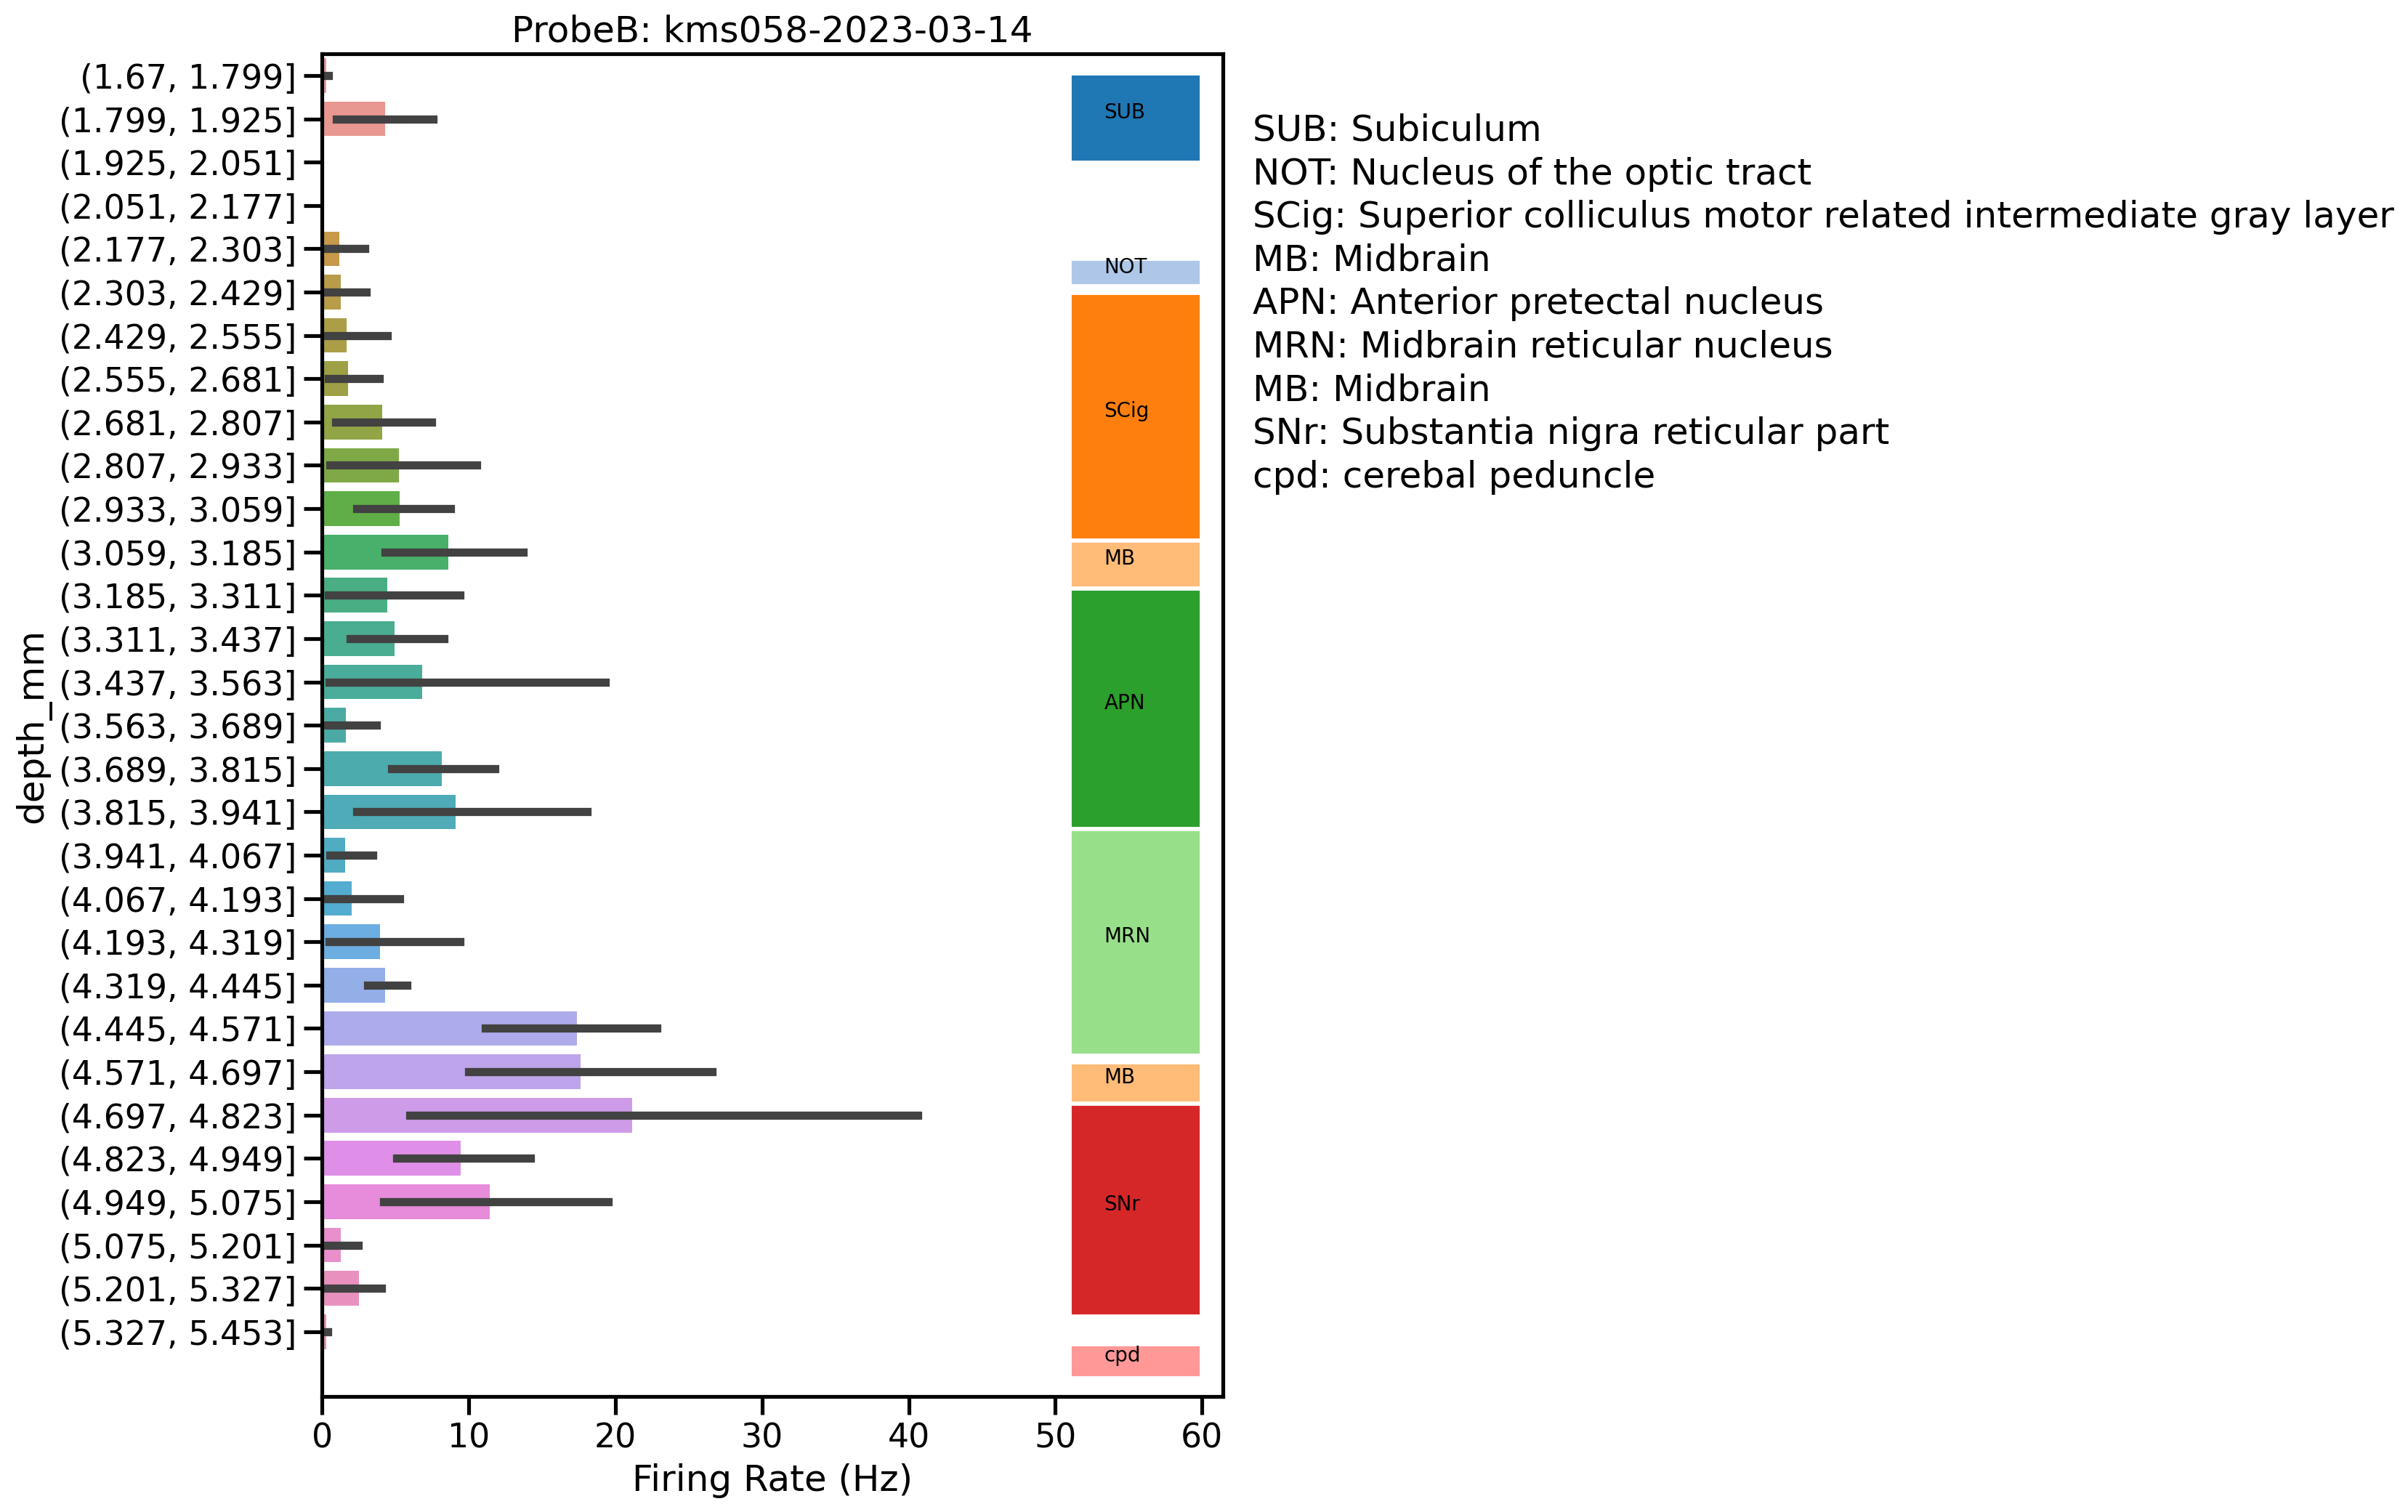

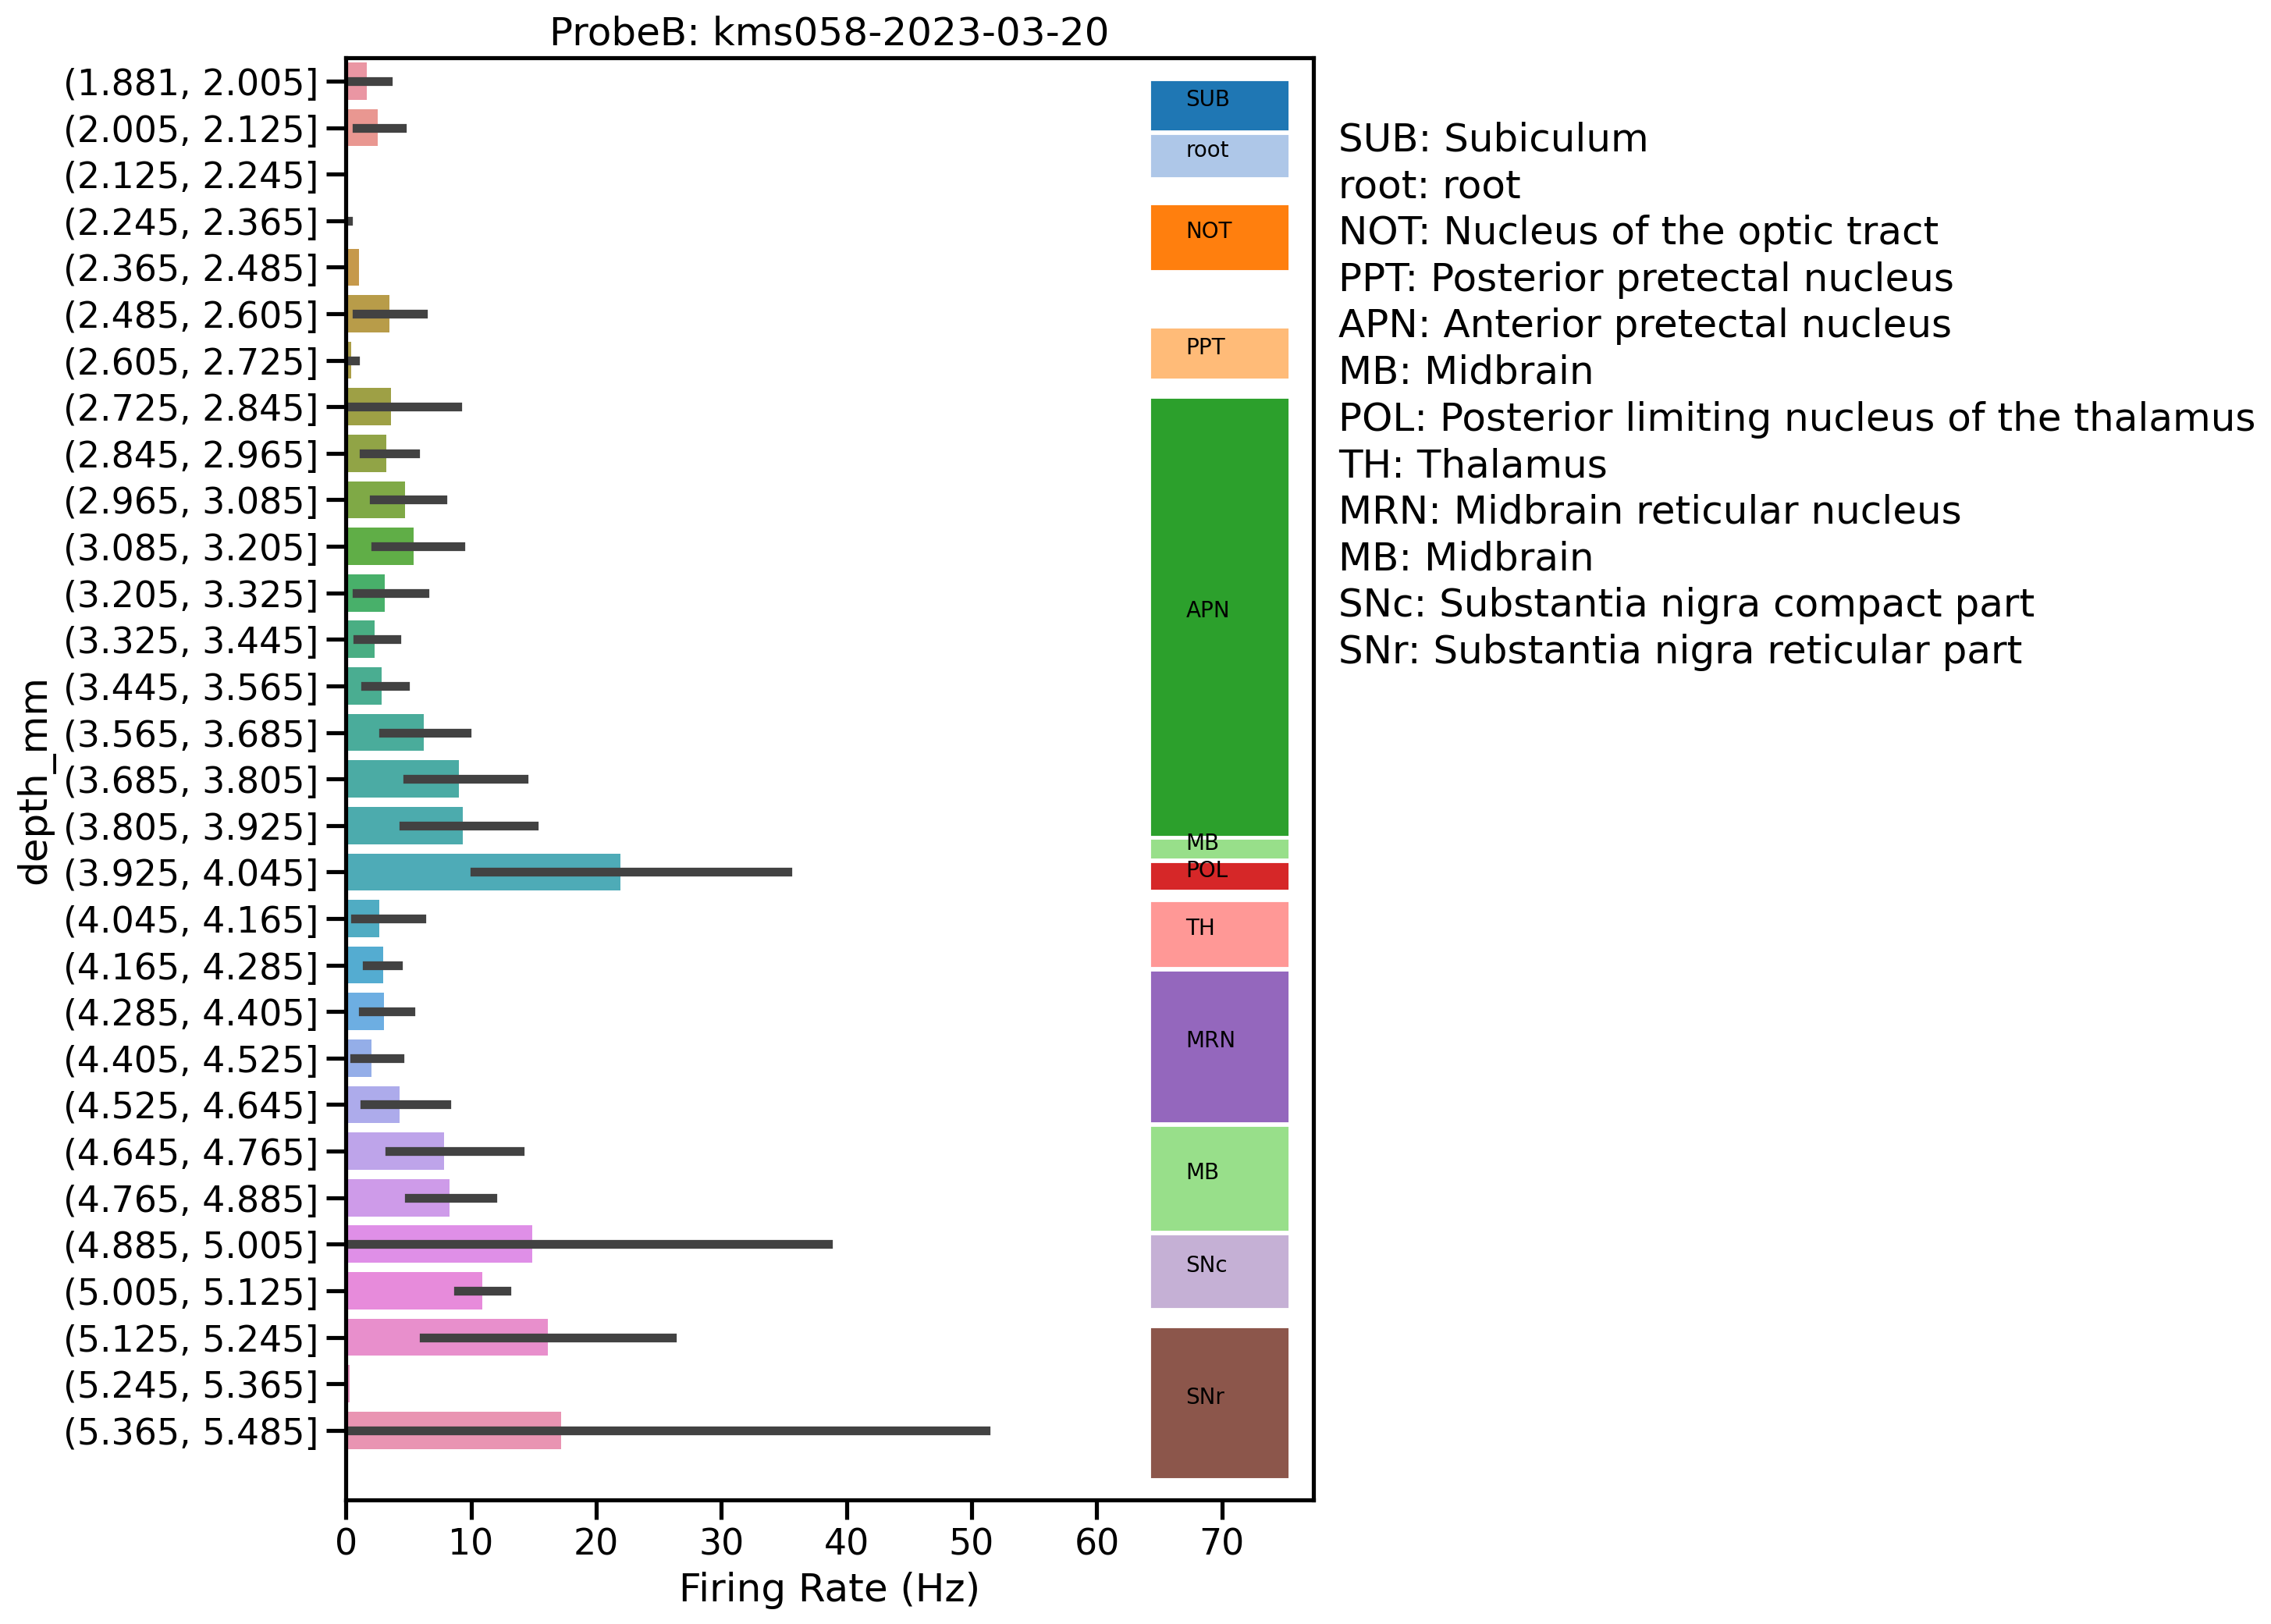

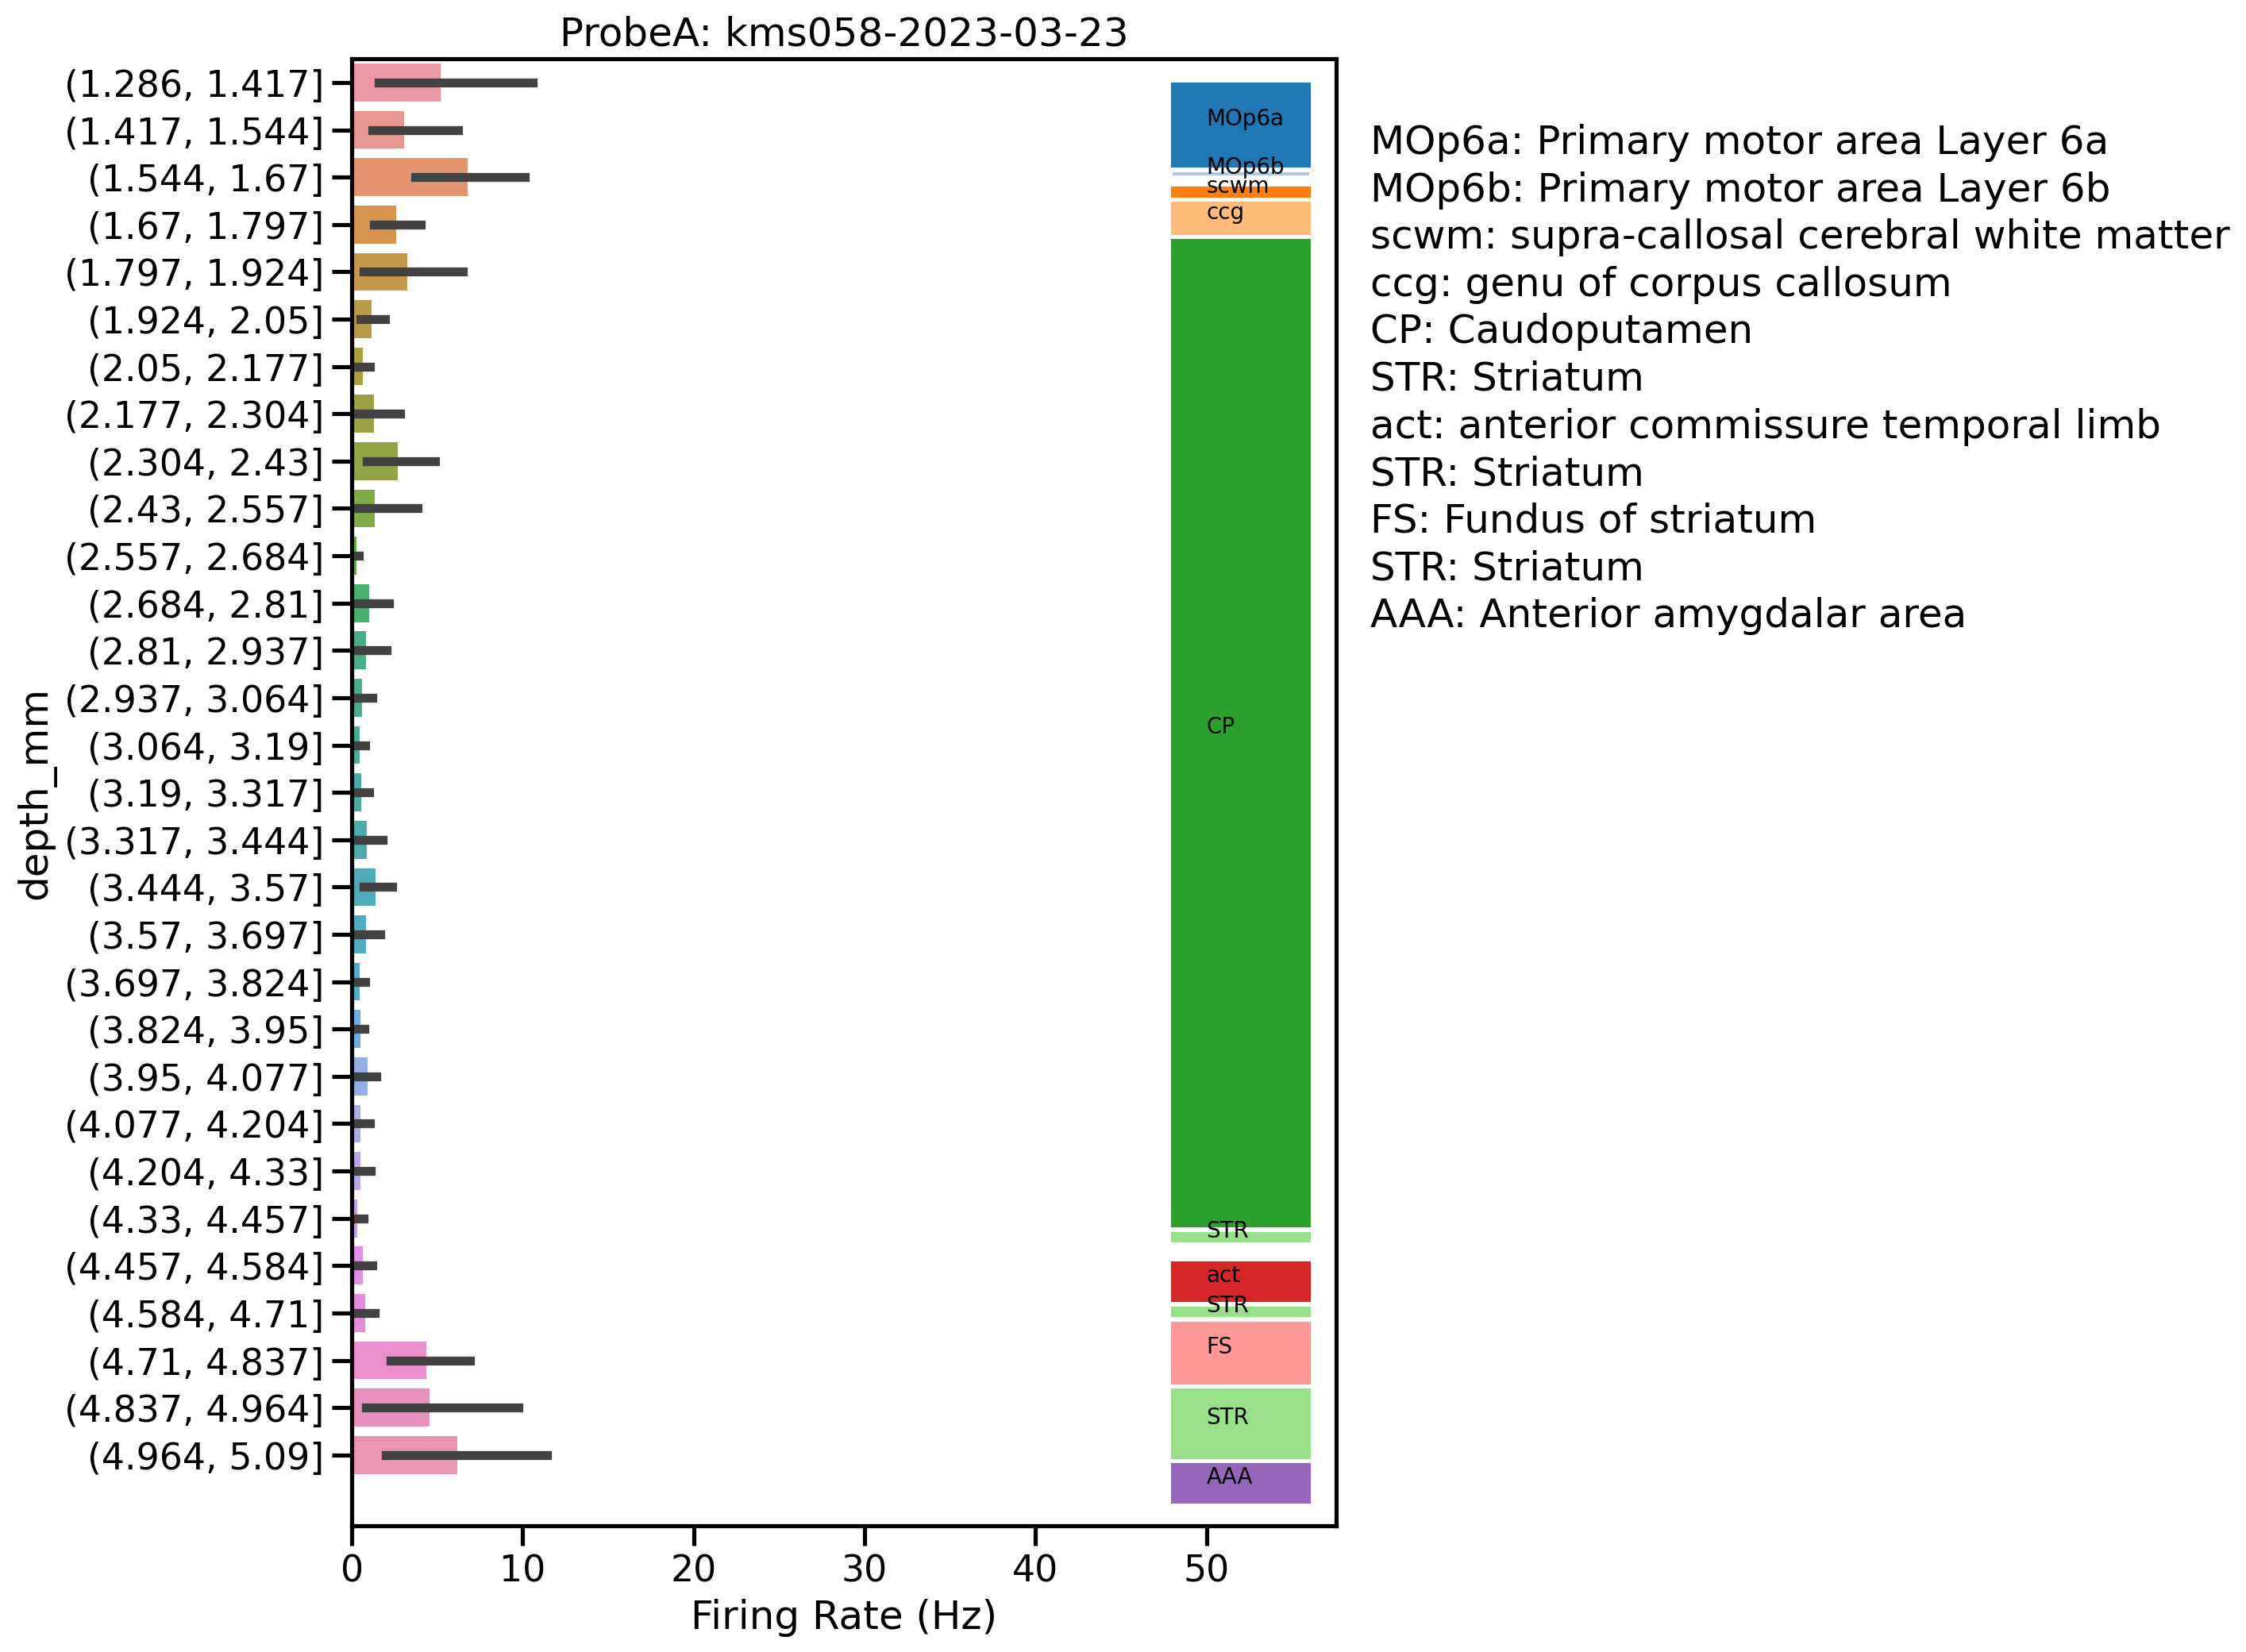

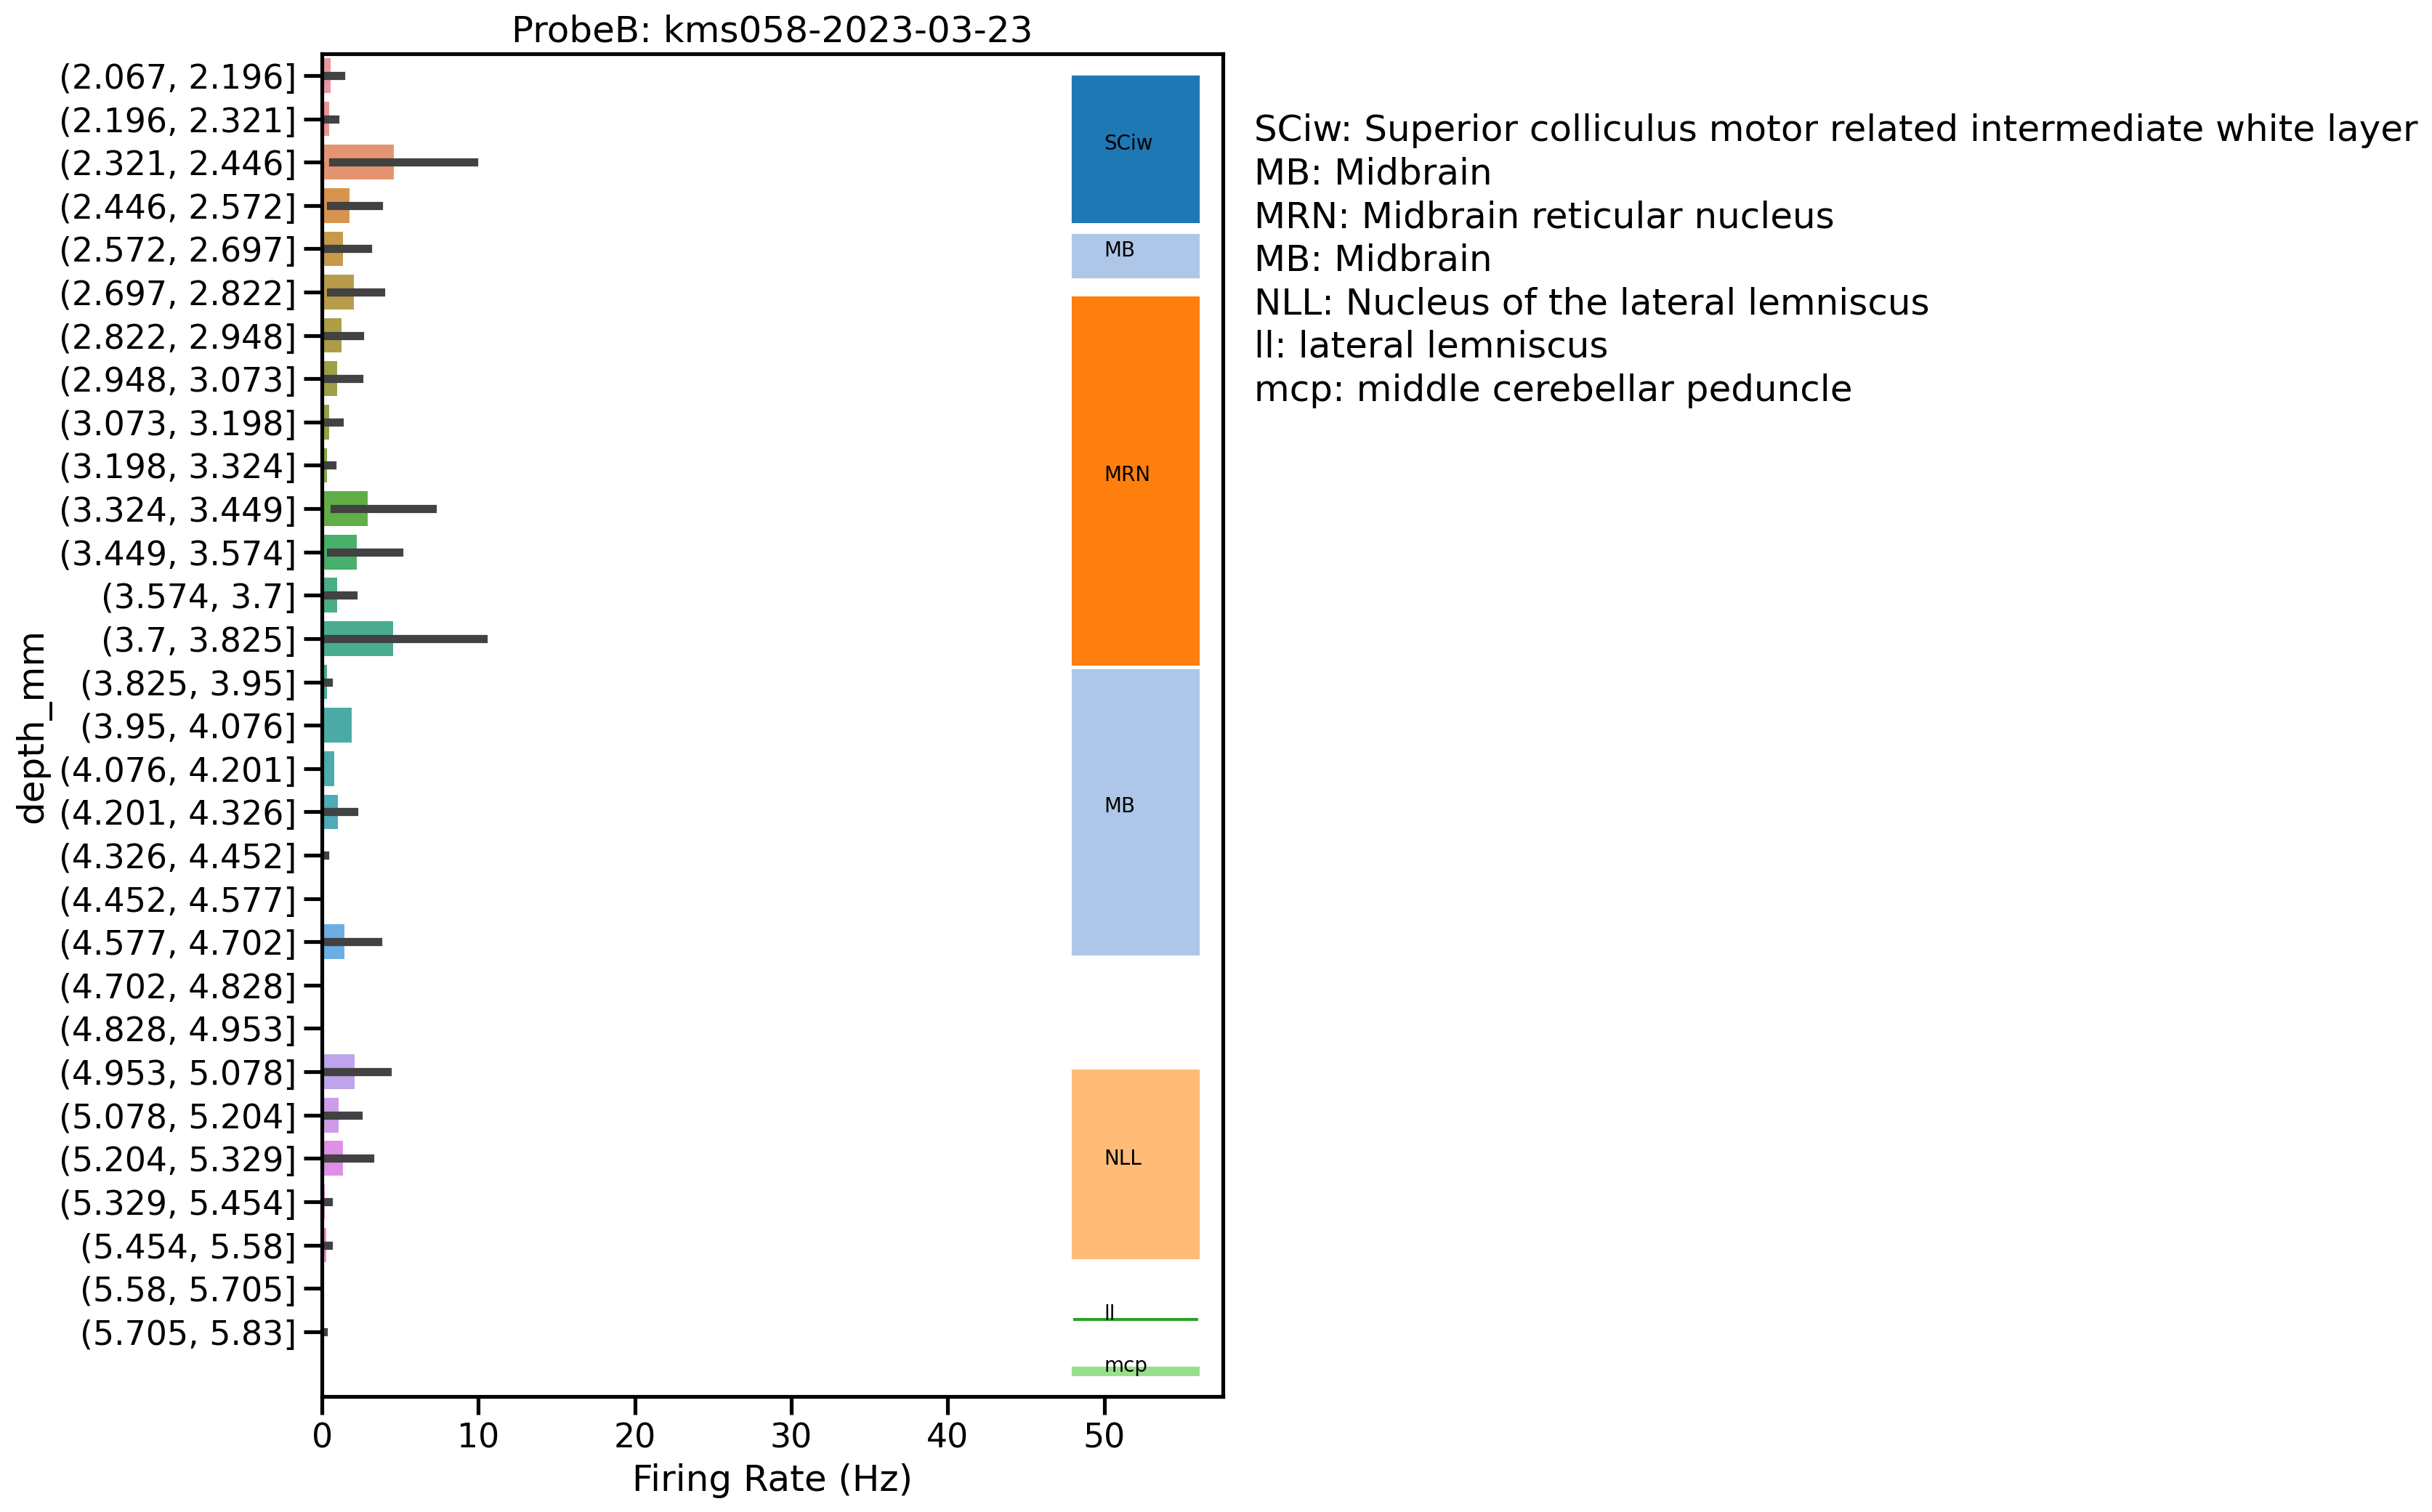

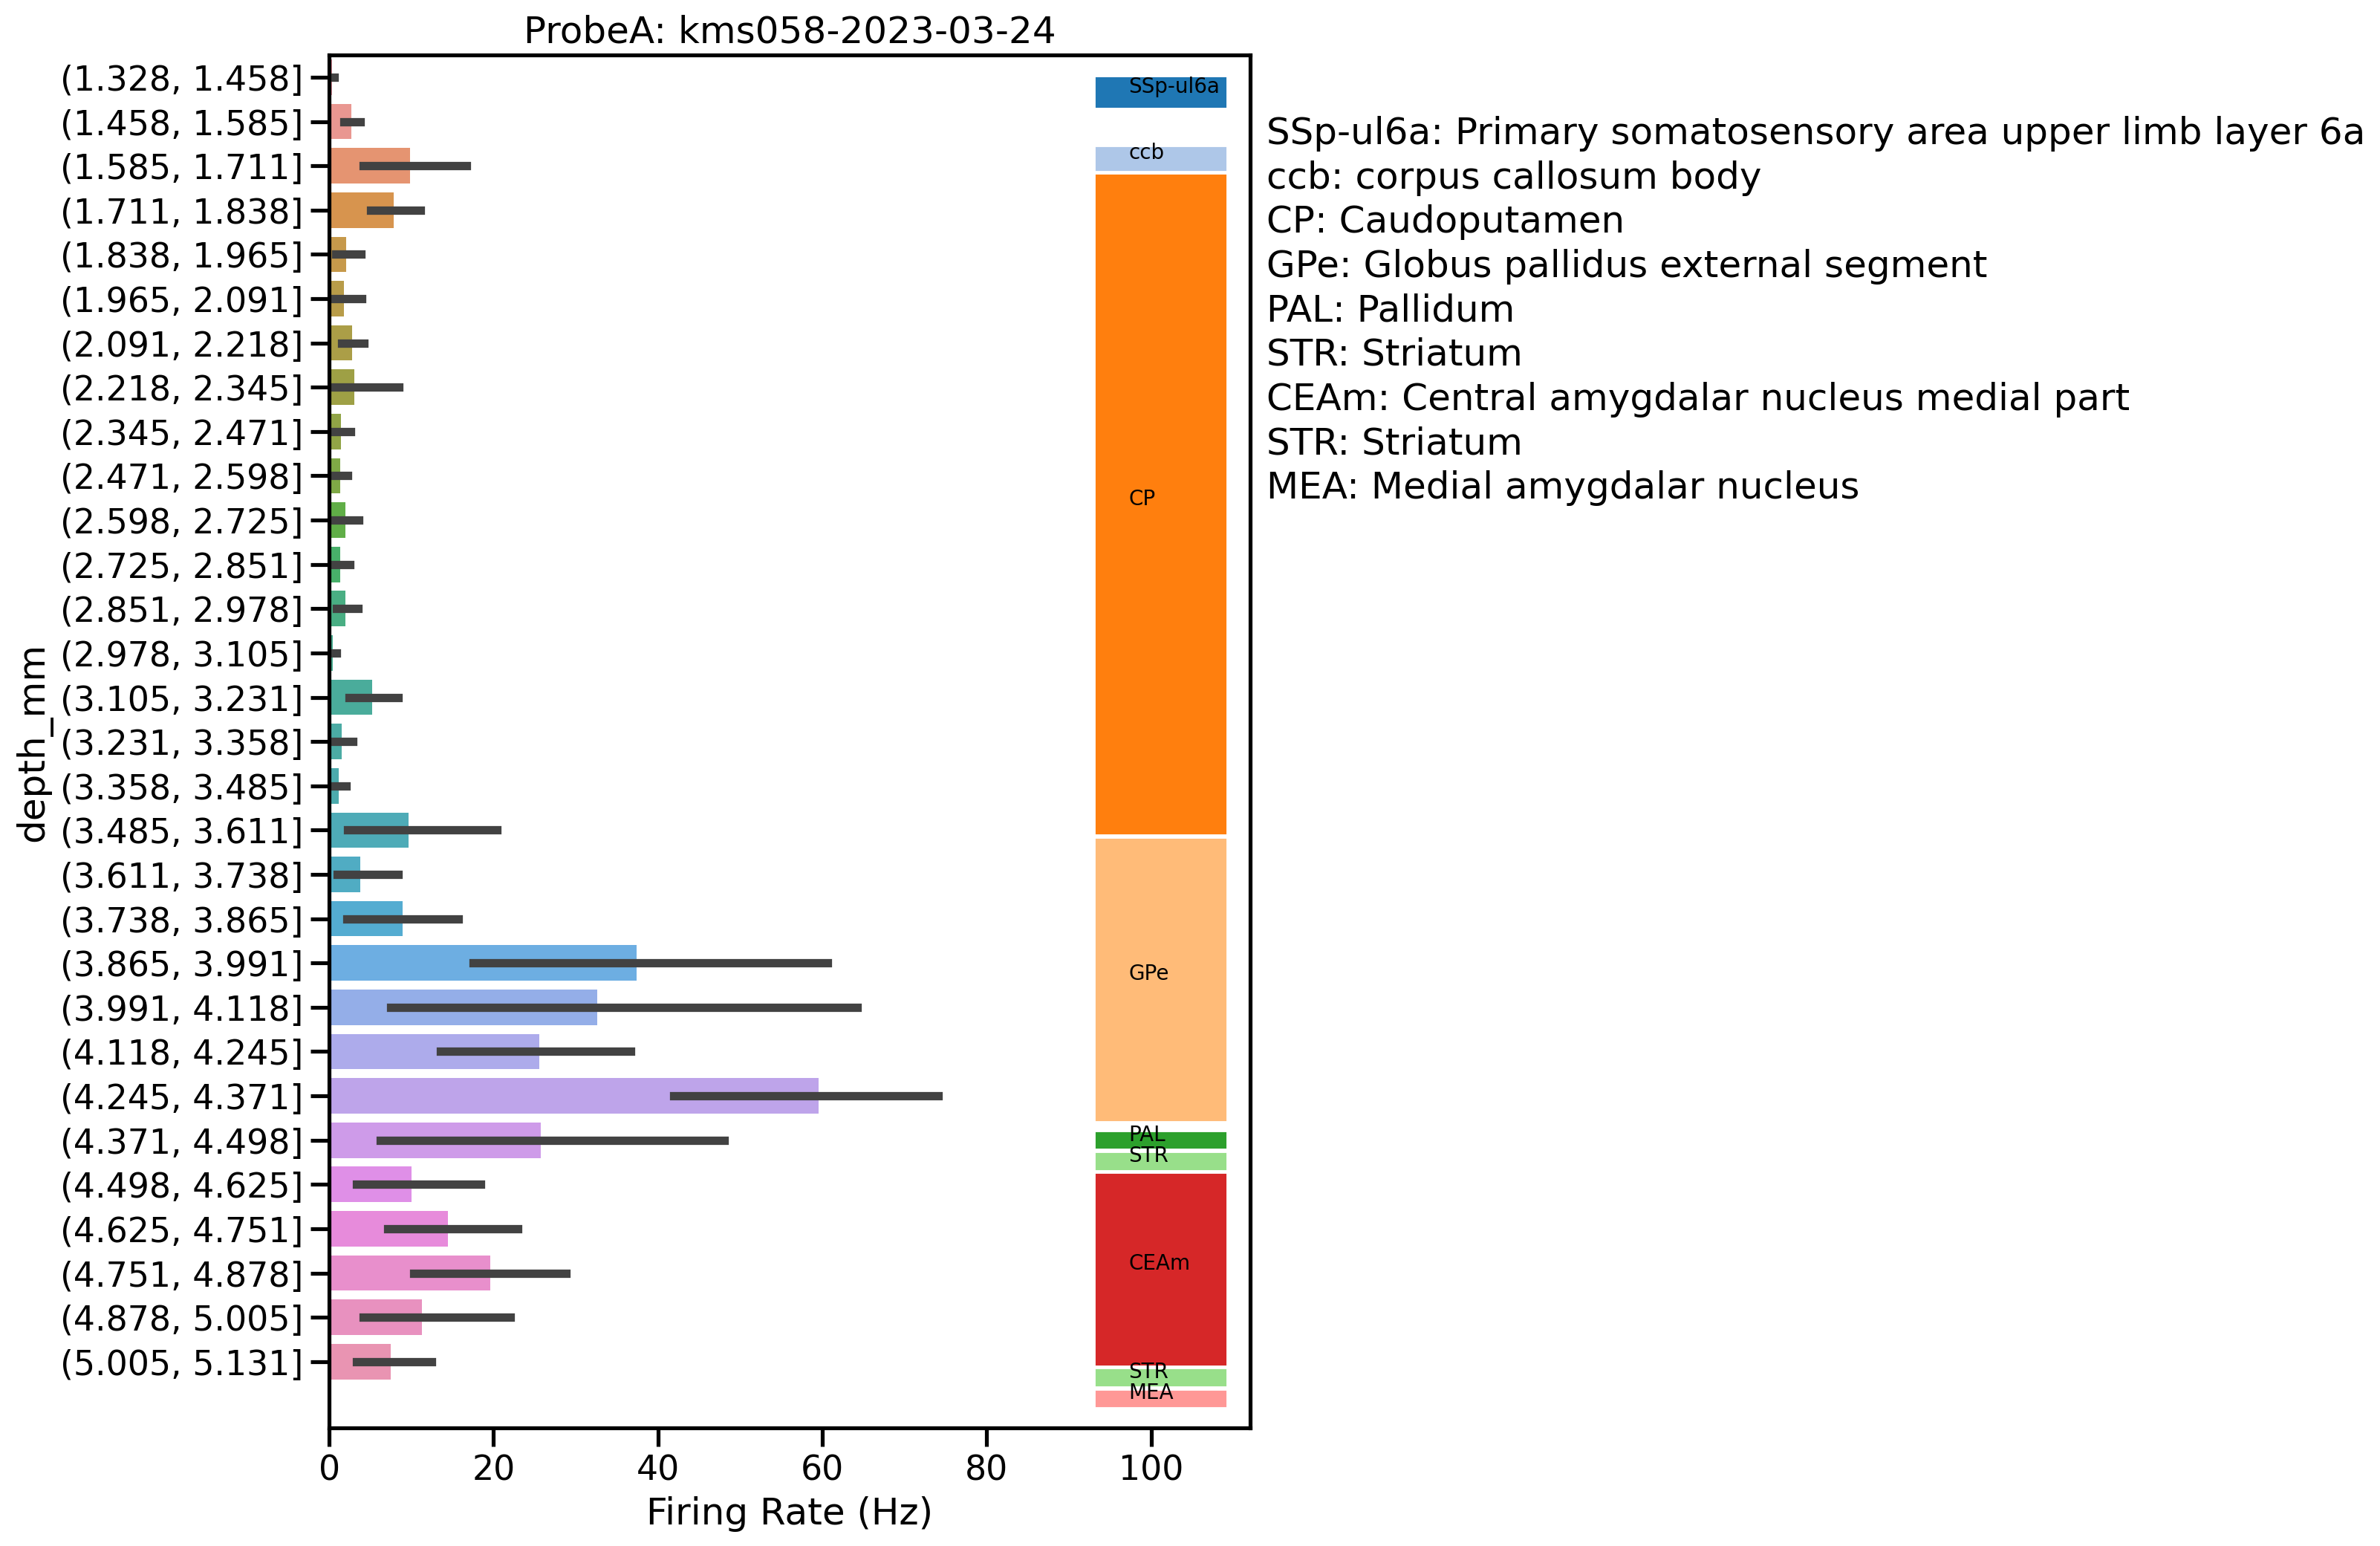

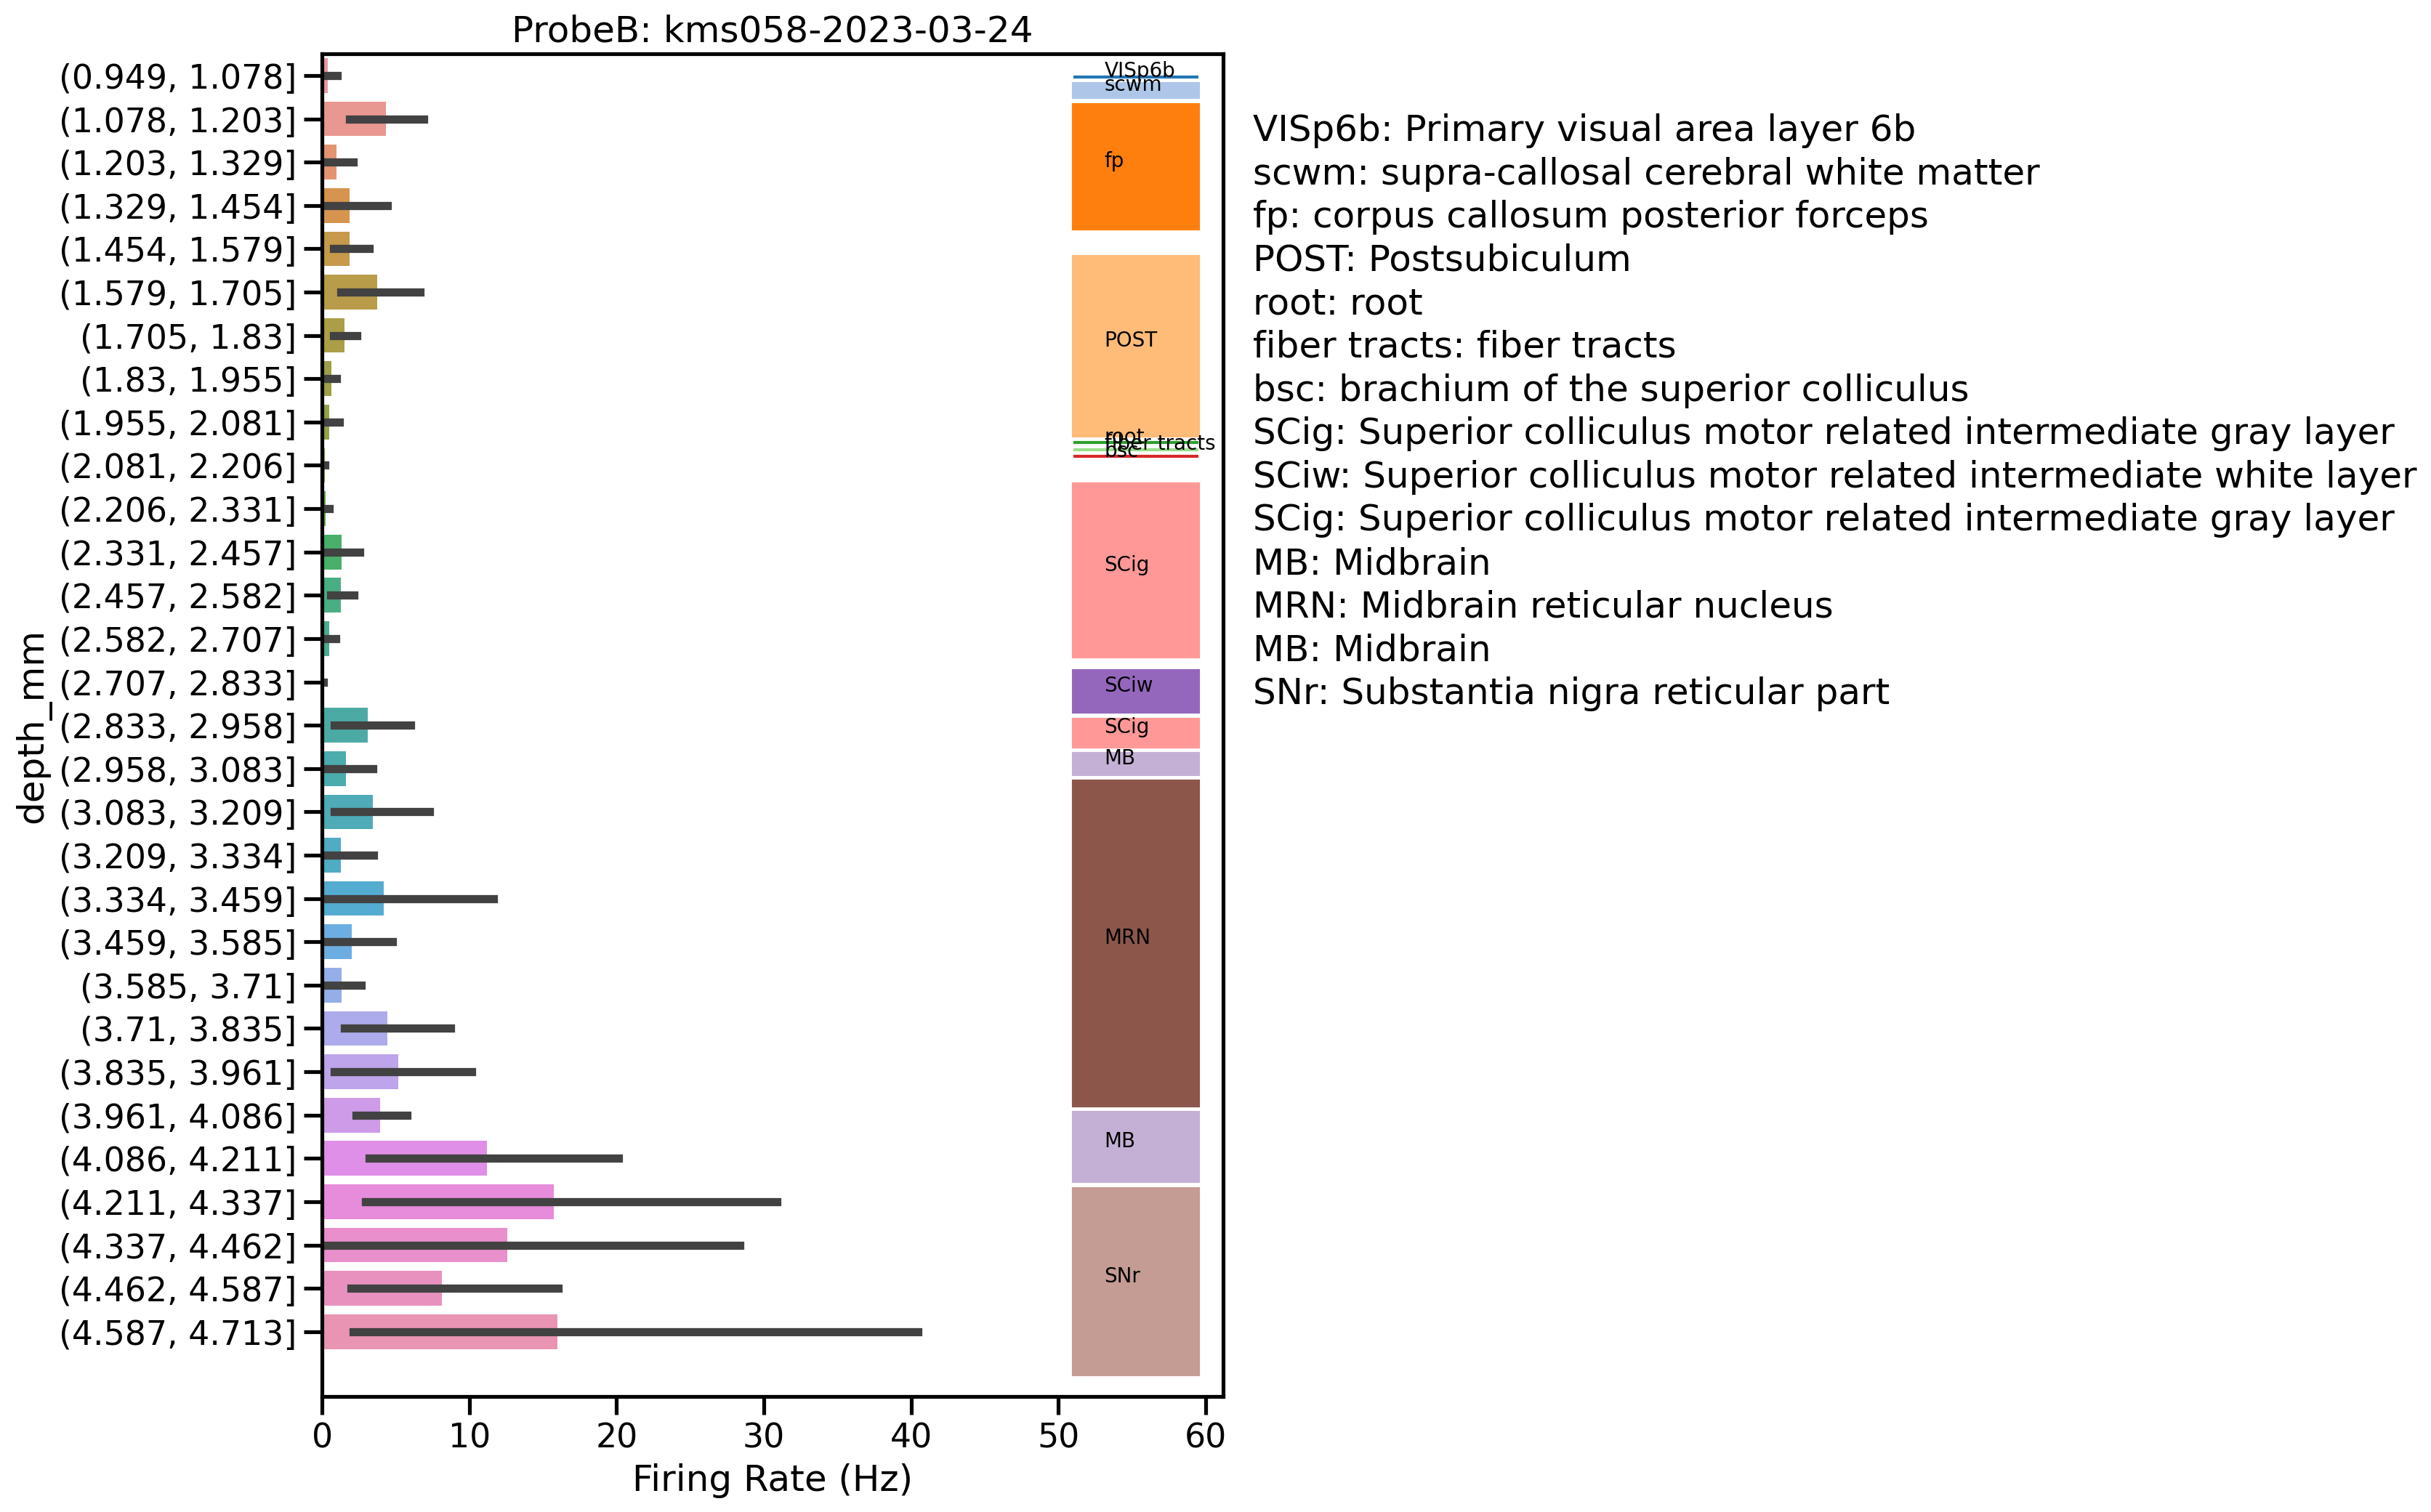

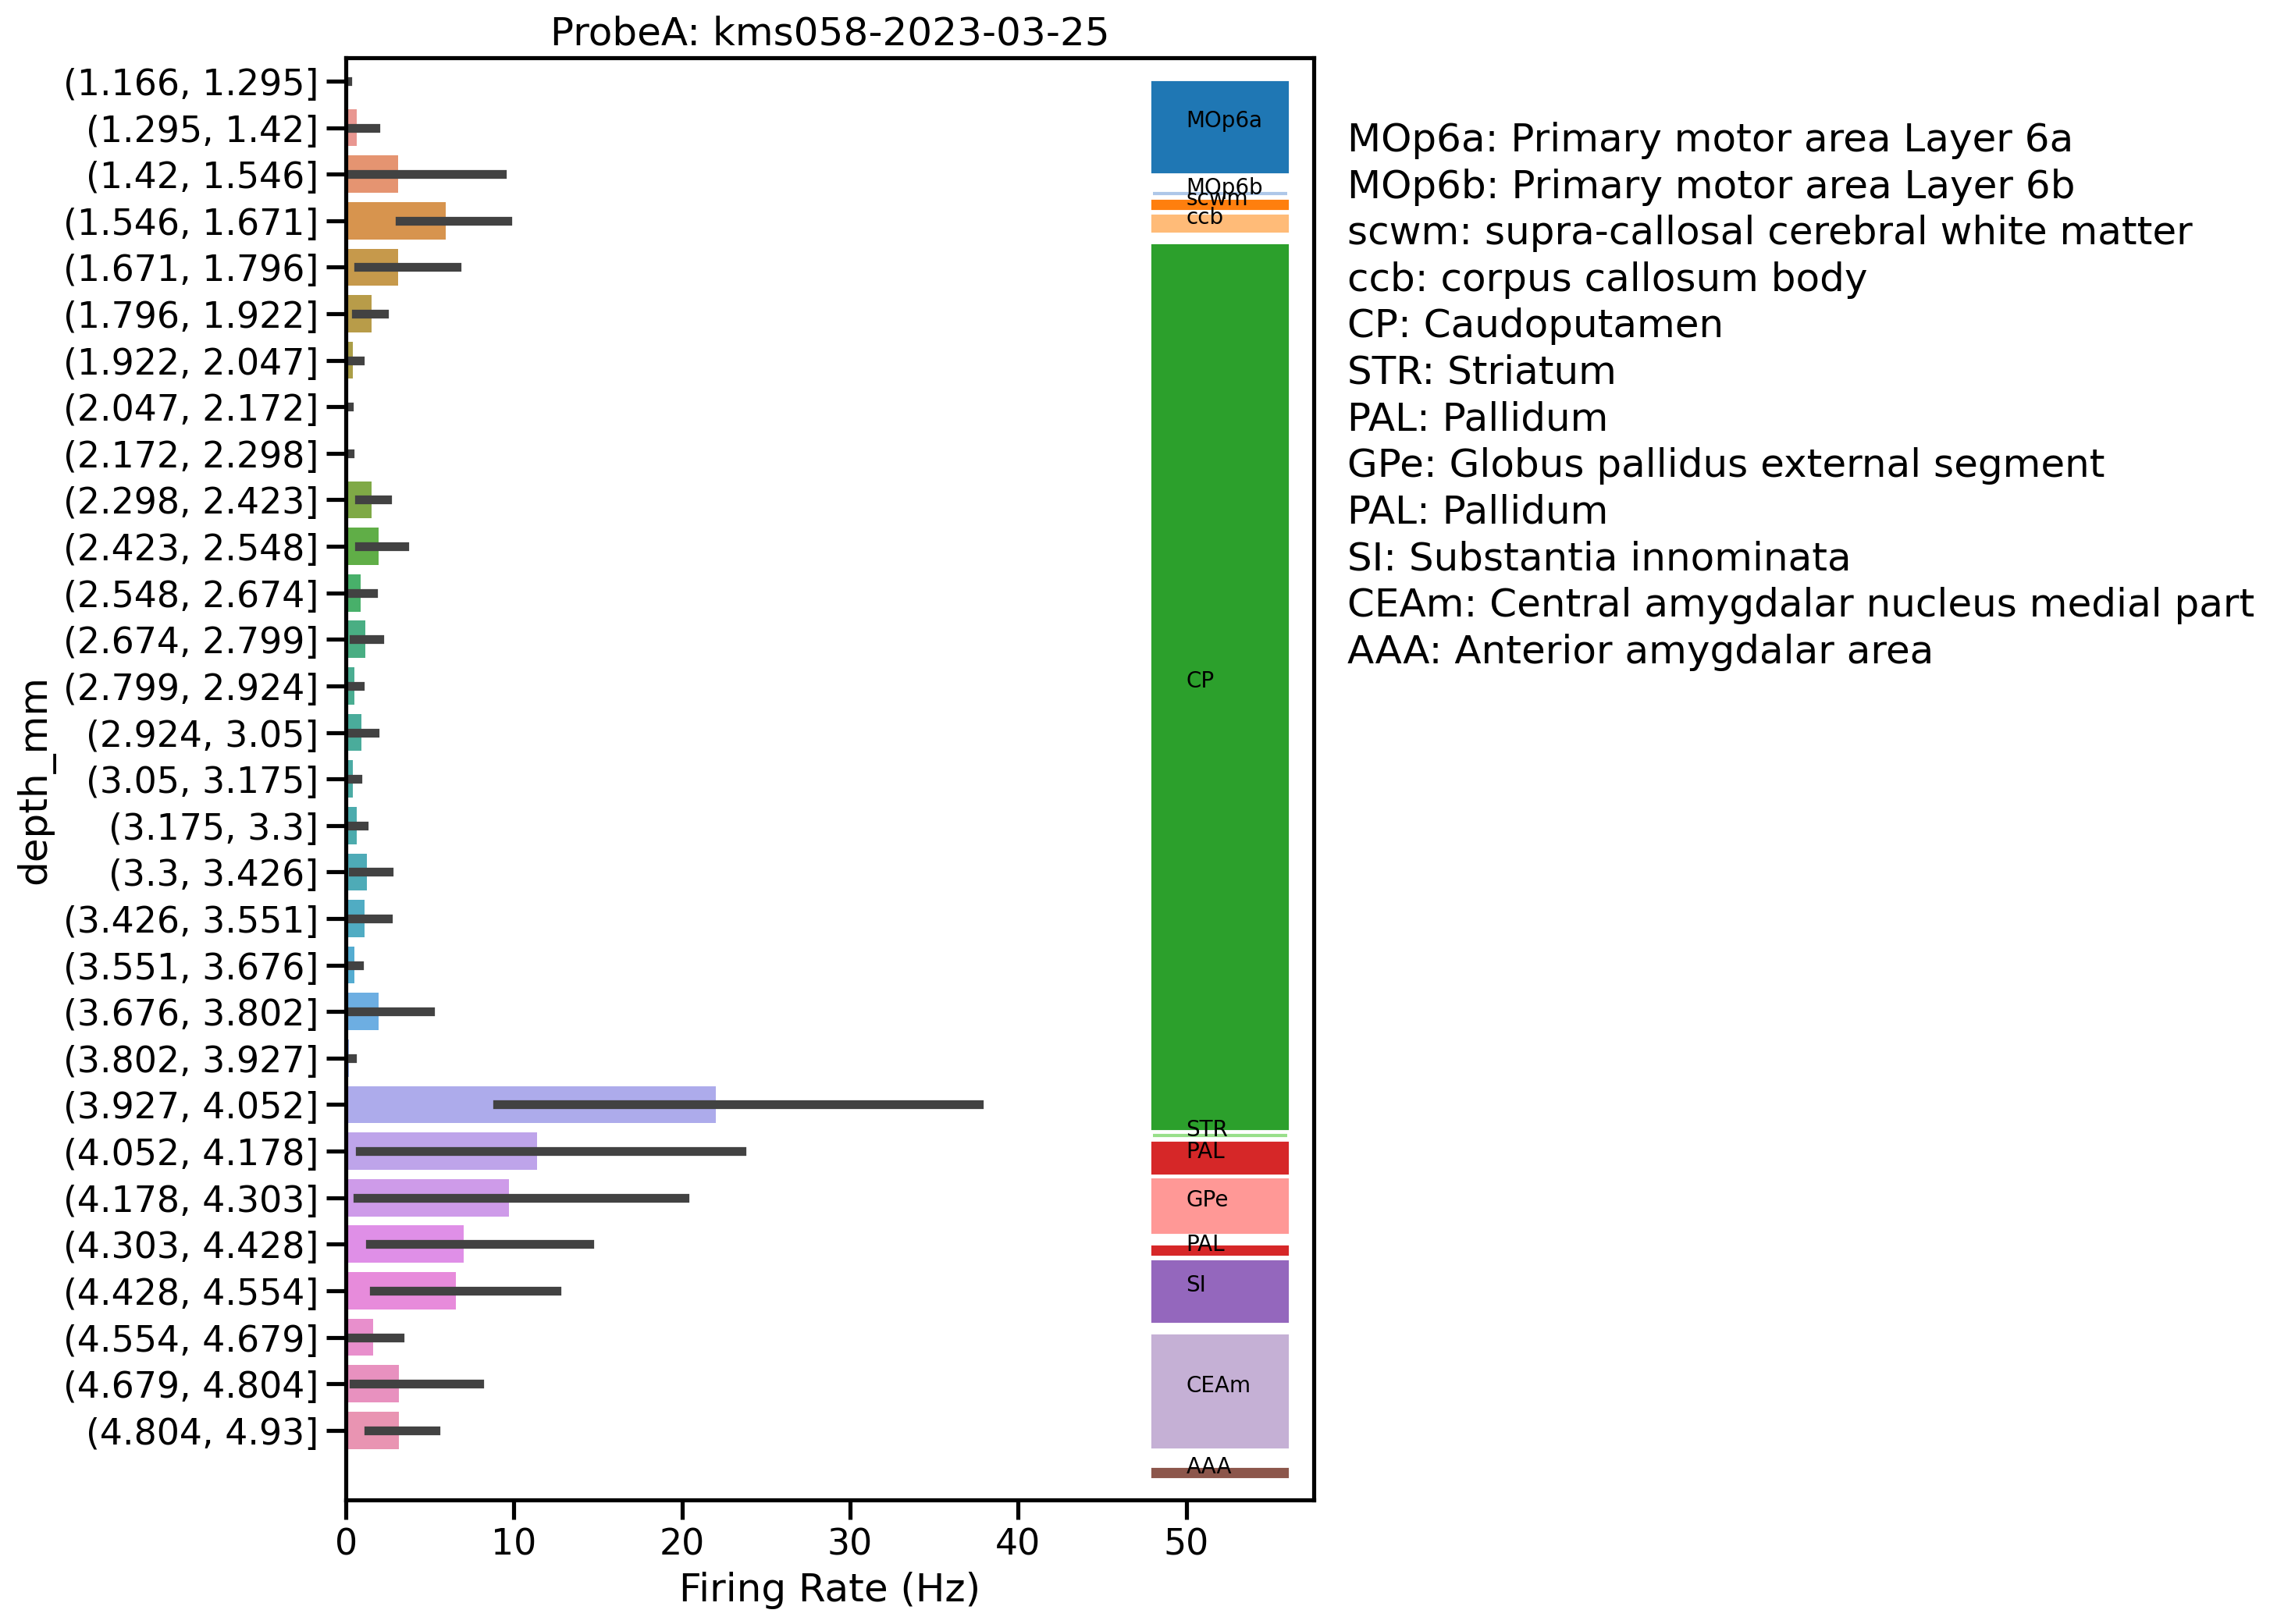

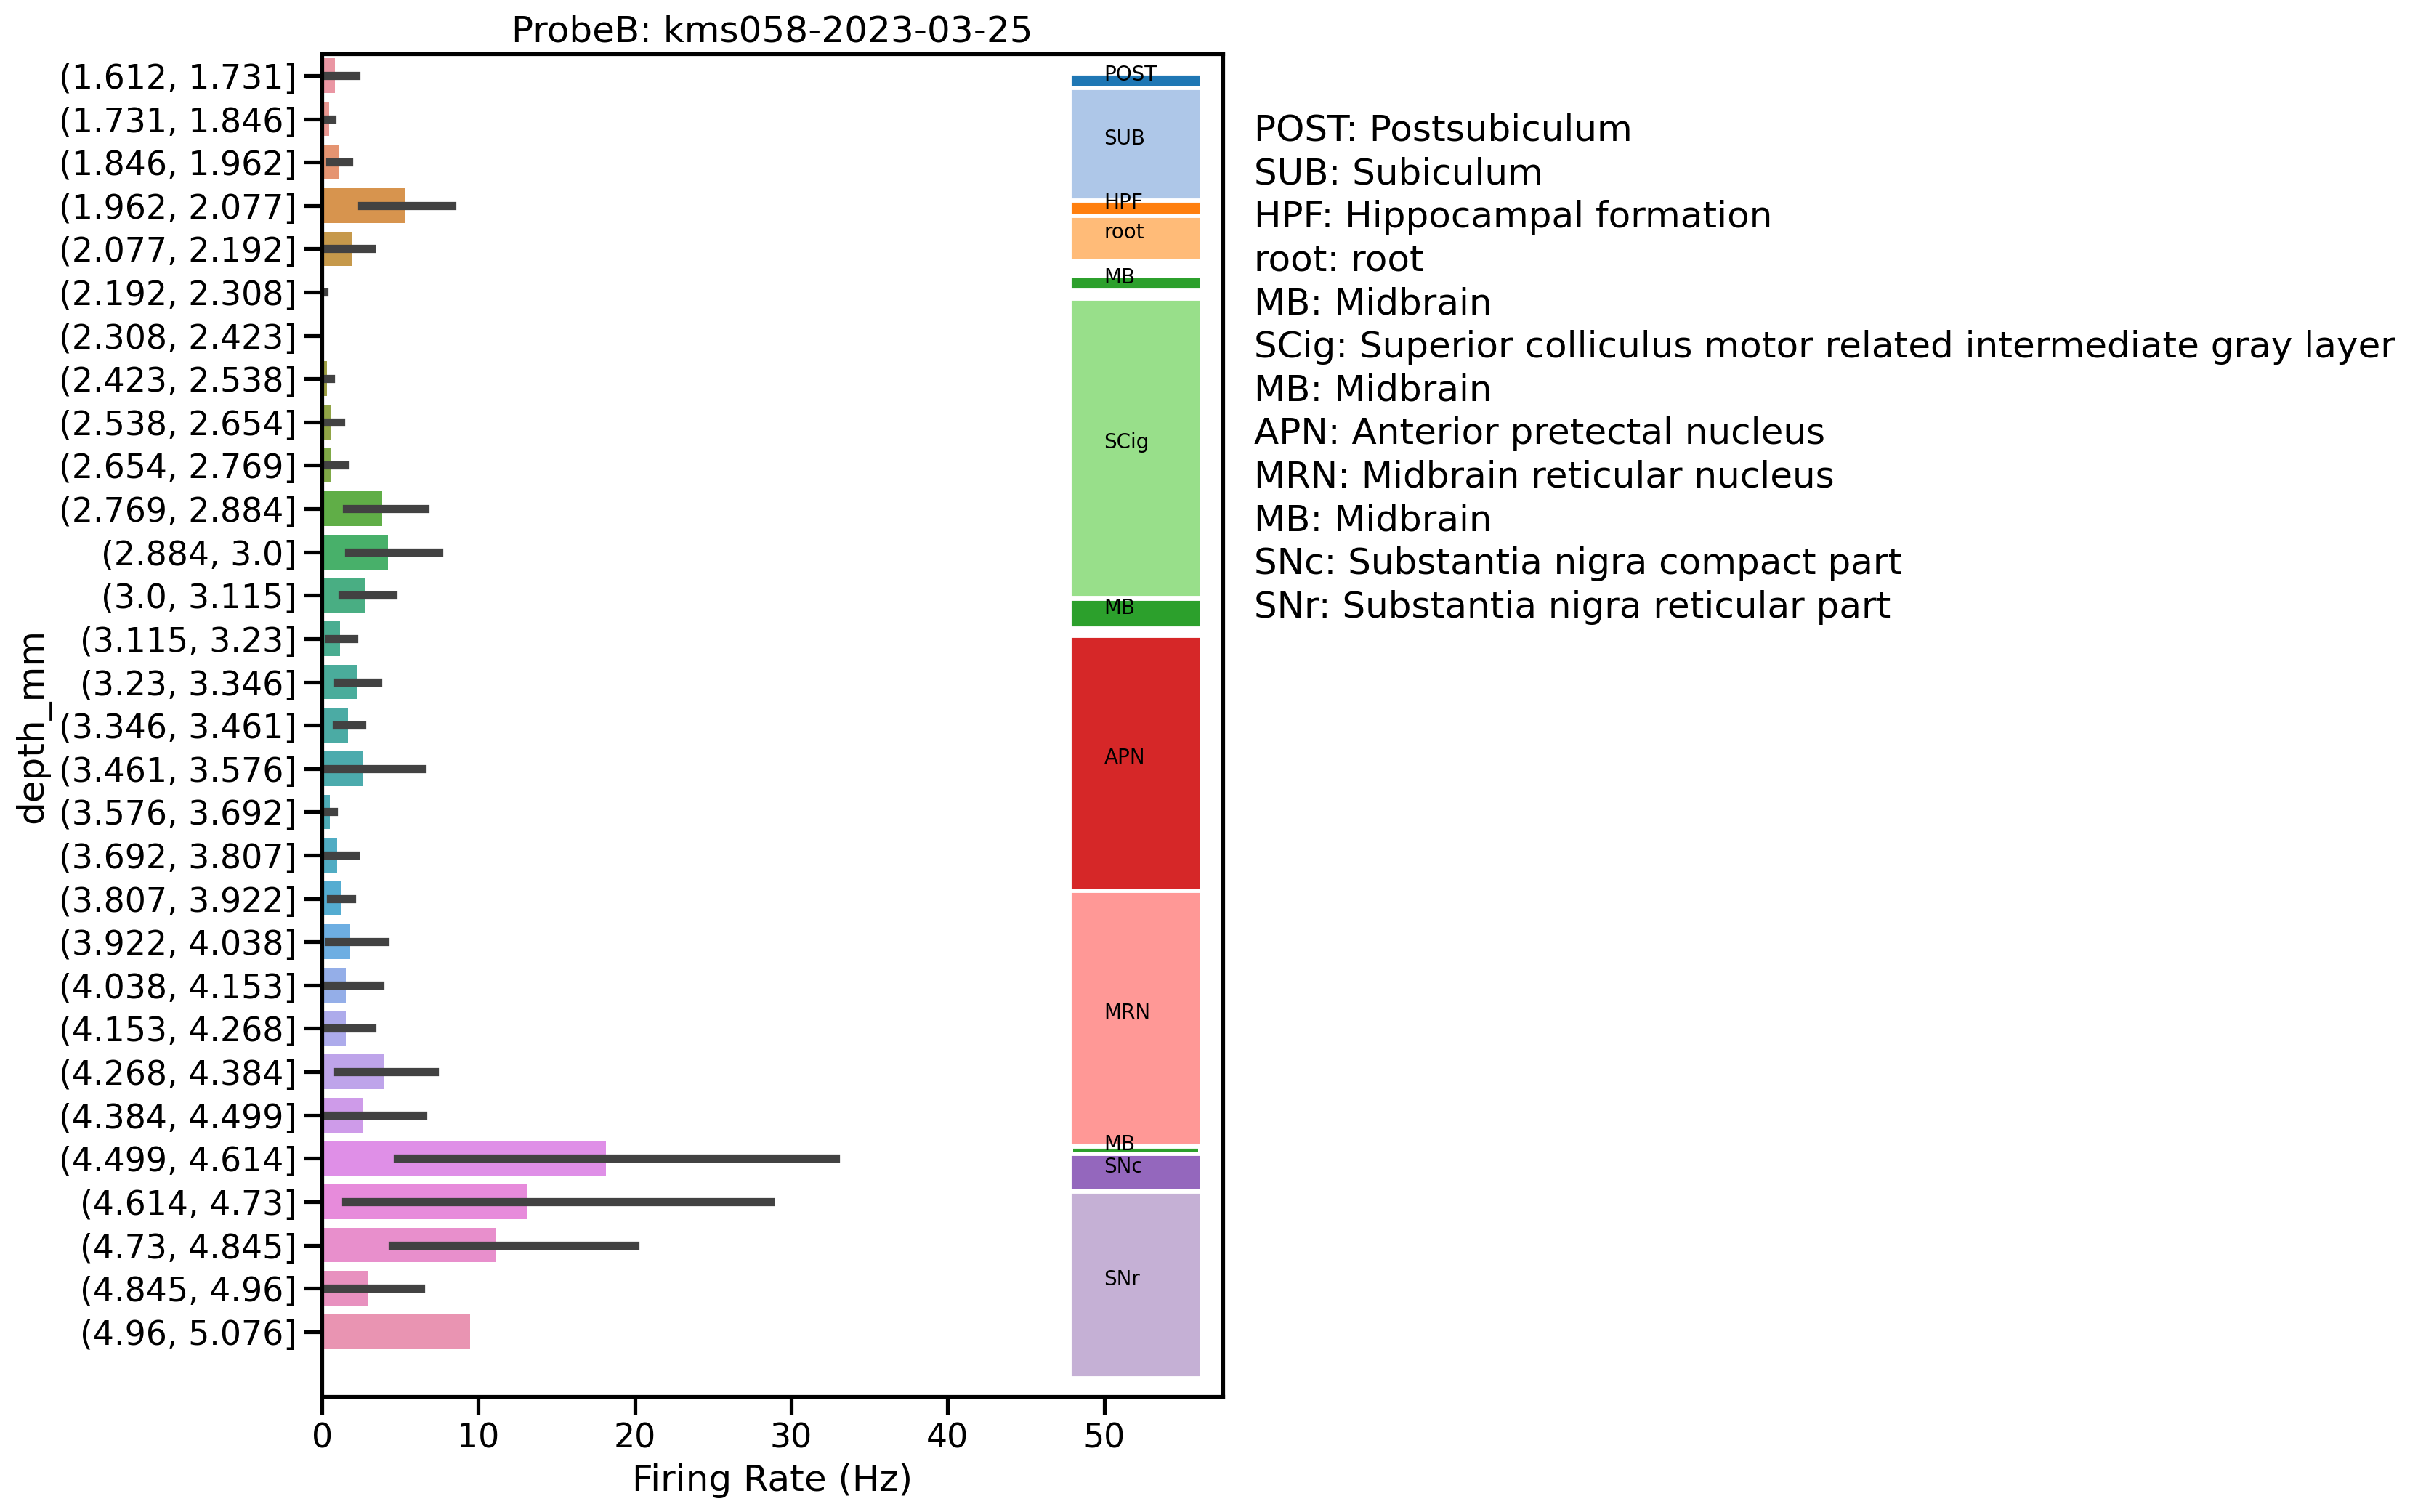

In [43]:
# TODO: figure out the best way to display aggregated data from multiple sessions
figure_output_path = sharp_track_path.parent/'ephys'

if not figure_output_path.exists():
    figure_output_path.mkdir()

for session_date in df_cell_merge.session_date.unique():
    for probe in ['A','B']:
        df_cell_probe= df_cell_merge[(df_cell_merge.probe_AB==probe) & (df_cell_merge.session_date == session_date)].copy()
        if len(df_cell_probe)>0:
            ax = anat_utils.plot_firing_rate_regions(df_cell_probe)
            ax.set_title(f'Probe{probe}: {session_date}')
            plt.savefig(figure_output_path/f'FiringRate_depth_Probe{probe}_{session_date}.png',dpi=200, bbox_inches='tight')

## Also plot aggregated firing rate in different brain regions

### Firing rate

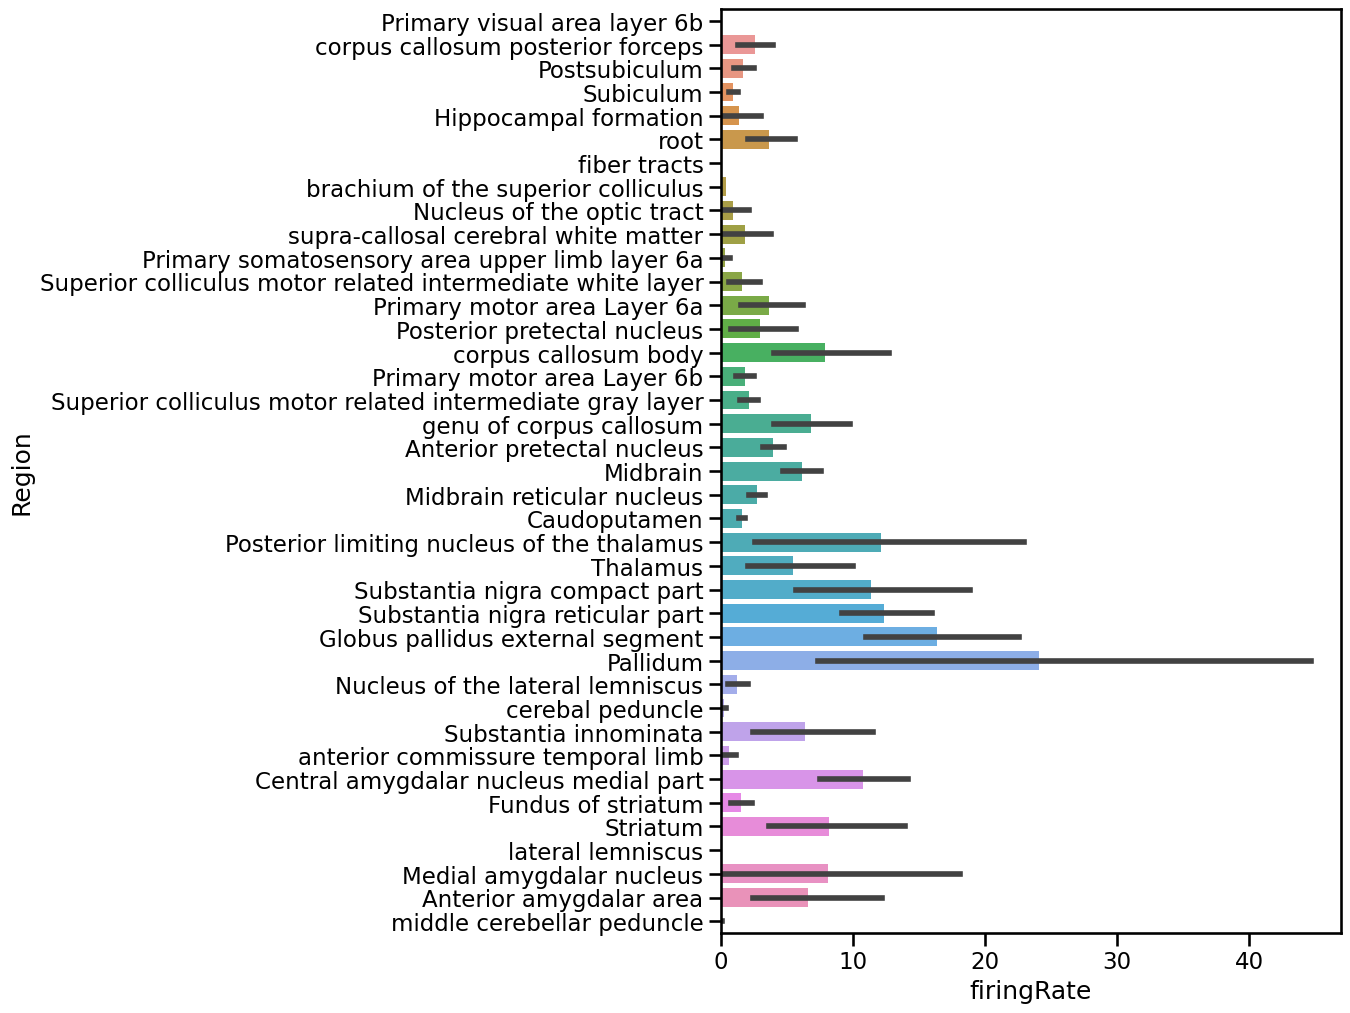

In [45]:
plt.figure(figsize=(8,12))
sns.set_context('talk')
df2plot = df_cell_merge
region_position = df2plot.groupby('name')['dv_mm'].mean().sort_values()
ax = sns.barplot(df2plot, y='name', x='firingRate', order=region_position.index)
ax.set_ylabel('Region')
plt.savefig(figure_output_path/'firing_rate_regions.png',dpi=300,bbox_inches='tight')

### Cell counts

<Figure size 800x1200 with 0 Axes>

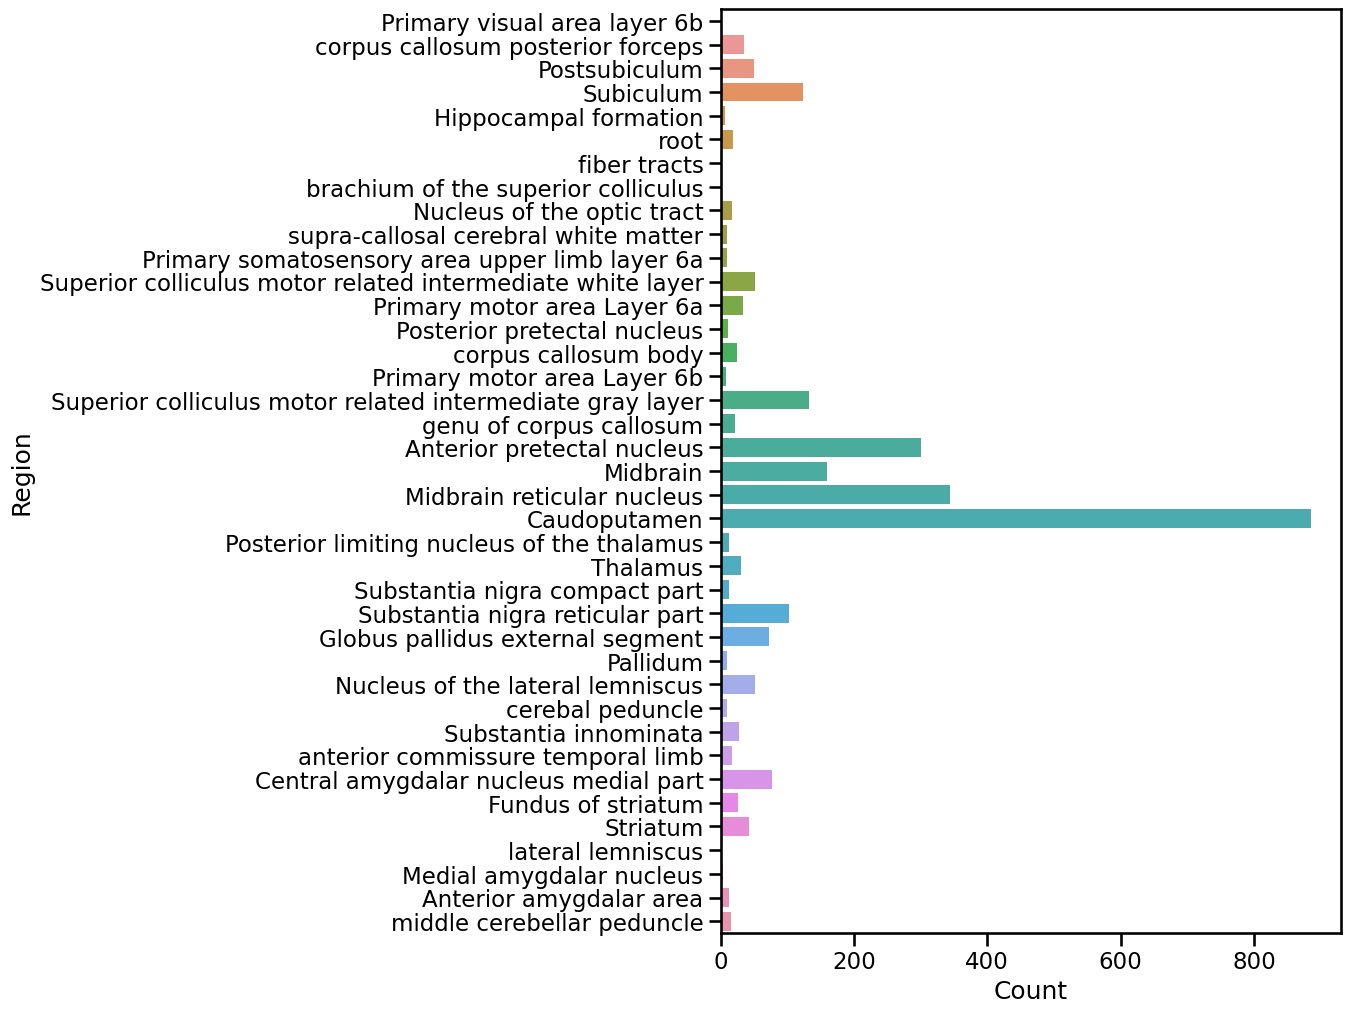

In [46]:
plt.figure(figsize=(8,12))
cell_count = df2plot.groupby('name')['cluID'].count().reset_index()
plt.figure(figsize=(8,12))
ax = sns.barplot(cell_count, x='cluID', y='name', order=region_position.index)
ax.set_xlabel('Count')
ax.set_ylabel('Region')

plt.savefig(figure_output_path/'cell_count_regions.png',dpi=300,bbox_inches='tight')

## Copy outputs

In [47]:
# also copy all outputs to a central location
dest_path = agg_output_path/'sharp_track'/animal_id

shutil.copytree(figure_output_path, dest_path, dirs_exist_ok=True)
df_sharptrack.to_pickle(dest_path/'df_sharptrack.pkl')
df_cell_merge.to_pickle(dest_path/'df_cell_merge.pkl')